# Set 1 - Full Code

## Importing Libraries

In [1]:
# Data Management
import numpy as np
import pandas as pd
import scipy as sp
from pandas import DataFrame 
from kneed import KneeLocator

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

### Ecopy function distance() from https://github.com/Auerilas/ecopy/blob/master/ecopy/ordination/distance.py

In [2]:
def distance(x, method='euclidean', transform="1", breakNA=True):
    '''
    Docstring for function ecopy.distance
    ========================
    Computes a dissimilarity matrix from a given matrix,
        where distances are calculated among rows. Multiple
        similarity/dissimilarity metrics are possible, and it is
        up to the user to choose the correct one. In the case of similarity
        metrics, dissimilarity is calculated as 1-D unless otherwise specified.
        See Legendre and Legendre for details on coefficients.

    For binary coefficients, A is # shared similarities, B and C are #'s of
        differences, and D is # of shared absences

    Most quantitative (i.e. non-binary) metrics will work with binary data.
        In fact, some methods are redundant. For example, bray = sorensen 
        when bray is passed a binary data frame. However, both methods are 
        provided here for simplicity and clarity

    Use
    ----
    distance(x, method='euclidean', transform="1", breakNA=True)

    Returns a numpy.ndarray square, symmetric matrix

    Parameters
    ----------
    x:  numpy array or pandas dataframe with observations as rows
        and descriptors as columns
    method: a method used for calculating similarities
        euclidean: calculates euclidean distance between rows (default)
                sqrt(d1^2 + d2^2 + ... + dn^2)
        gow_euclidean: calculates euclidean distance between rows, removing NAs
                sqrt(delta*(x1-x2)**2/sum(delta))
                where delta = 1 if both observations present, 0 otherwise
        chord: calculates the chord distance between rows
                this is the euclidean distance of normalized vectors
        manhattan: manhattan distance between rows
                sum(abs(xik - xjk)) over all k
        meanChar: Czekanowski's mean character difference
                1/M*(sum(abs(xik - xjk))) over all k
                where M is the number of columns
        whittaker: Whittaker's index of association
                0.5*sum(abs(x1-x2)) where x1 and x2 are
                first standardized by vector totals (x1/sum(x1))
        canberra: Canberra metric
                sum(abs(xik-xjk) / (xik+xjk))*1/M 
                where M is the number of species present at both sites
        hellinger: Hellinger distance
                same as the chord but square-root transformed first
        mod_gower: modified Gower distance
                same as meanChar except M is the number of 
                columns that are not double zero
         simple: simple matching of binary data (SIMILARITY)
                (A + D)/(A + B + C + D)
        rogers: Rogers and Tanimoto coefficient for binary data (SIMILARITY)
                (A + D) / (A + 2B + 2C + D)
        sokal: Sokal and Sneath coefficient for binary data (SIMILARITY)
                (2A + 2D)/(2A + B + C + 2D)
        jaccard: Jaccard's coefficient for binary data (SIMILARITY)
                A/(A + B + C)
        sorensen: Sorensen's coefficient for binary data (SIMILARITY)
                2A/(2A + B + C)
        kulczynski: Kulczynski's coefficient (SIMILARITY)
                0.5*(sum(min(xi,xj))/sum(xi) + sum(min(xi,xj))/sum(xj))
        ochiai: Ochiai's coefficient for binary data (SIMILARITY)
                A/sqrt((A + B)(A + C))
        bray: Bray-Curtis coefficient (SIMILARITY)
                2*sum(min(xi, xj))/(sum(xi) + sum(xj))
        gower: Gower assymetrical coefficient (SIMILARITY)
                (1-(abs(xik - xjk))/(max(xk)-min(xk)))*1/M
                where k is species and M is the number of columns.
                The denominator is the maximum of species k minus the min of 
                species k in the entire matrix. Note that double zero columns
                are excluded here.
        NOTE: All metrics denoted as SIMILARITY are transformed to dissimilarity using
            D = 1 - Similarity
    transform: how should dissimilarities be transformed.
        "1": D (default)
        "sqrt": sqrt(D)
    breakNA: should the process halt if the matrix contains any NAs?
        if False, then NA's undergo pairwise deletion during distance calculation,
        such that when calculating the distance between two rows, if any
        species is missing from a row, that species is removed from both rows

    Example
    --------
    import ecopy as ep
    varespec = ep.load_data('varespec')
    distance(varespec, method='euclidean')

    # for binary data
    varespec[varespec>0] = 1
    distance(varespec, method='jaccard)
    '''
    listofmethods =['euclidean', 'gow_euclidean', 'simple', 'rogers', 'sokal', 'jaccard', 'sorensen', 'kulczynski', 'bray', 'gower', 'chord', 'manhattan', 'meanChar', 'whittaker', 'canberra', 'hellinger', 'mod_gower', 'ochiai']
    if not isinstance(breakNA, bool):
        msg = 'removaNA argument must be boolean'
        raise ValueError(msg)
    if method not in listofmethods:
        msg = 'method argument {0!s} is not an accepted metric'.format(method)
        raise ValueError(msg)
    if not isinstance(x, (DataFrame, np.ndarray)):
        msg = 'x argument must be a numpy array or pandas dataframe'
        raise ValueError(msg)
    if isinstance(x, DataFrame):
        if (x.dtypes == 'object').any():
            msg = 'DataFrame can only contain numeric values'
            raise ValueError(msg)
        x = np.array(x)
    if breakNA:
        if np.isnan(np.sum(x)):
            msg = 'Matrix contains NA values'
            raise ValueError(msg)
    if np.min(np.sum(x, axis=1))==0:
        msg = 'One row is entirely zeros, distance calculations will be meaningless'
        raise ValueError(msg)
    if transform not in ['1', 'sqrt']:
        msg = 'transform argument must be "1" or "sqrt"'
        raise ValueError(msg)
    if method in ['simple', 'rogers', 'sokal', 'jaccard', 'sorensen', 'ochiai']:
        if np.any((x != 0) & (x != 1)):
            msg = 'For method {0}, data must be binary'.format(method)
            raise ValueError(msg)
    x = x.astype('float')
    if method == 'euclidean':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = eucFunc(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'gow_euclidean':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,:]
                x2 = x[j,:]
                delta = ~(np.isnan(x1) + np.isnan(x2))
                delta = delta.astype(int)
                x1[np.isnan(x1)] = -999
                x2[np.isnan(x2)] = -999
                distMat[i,j] = eucGow(x1, x2, delta, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'simple':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = simpleSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'rogers':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = rogerSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'sokal':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = sokalSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'jaccard':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = jaccardSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'sorensen':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = sorenSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'kulczynski':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = kulSim(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'bray':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = braySim(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'gower':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        R = np.apply_along_axis(lambda z: np.max(z) - np.min(z), 0, x)
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                R = R[~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                R = R[~np.isnan(x2)]
                distMat[i,j] = gowerSim(x1, x2, R, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'chord':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = chordDis(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'manhattan':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = manDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'meanChar':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = charDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'whittaker':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = whitDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'canberra':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = canDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'hellinger':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = chordDis(np.sqrt(x1), np.sqrt(x2), transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'mod_gower':
        if (x<0).any():
            msg = 'Distances are meaningless for negative numbers'
            raise ValueError(msg)
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                distMat[i,j] = m_gowDist(x1, x2, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)
    if method == 'ochiai':
        distMat = np.zeros((x.shape[0], x.shape[0]))
        for i in range(0, distMat.shape[0]):
            distMat[i,i] = 0
            for j in range(i+1, distMat.shape[0]):
                x1 = x[i,~np.isnan(x[i,:])]
                x2 = x[j,~np.isnan(x[i,:])]
                x1 = x1[~np.isnan(x2)]
                x2 = x2[~np.isnan(x2)]
                A, B, C, D = matchMat(x1, x2)
                distMat[i,j] = ochiaiSim(A, B, C, D, transform)
                distMat[j,i] = distMat[i,j]
        return(distMat)

def eucFunc(d1, d2, t):
    d = d1-d2
    eucD = np.sqrt(np.sum(np.square(d)))
    if t == "1":
        return eucD
    if t == "sqrt":
        return np.sqrt(eucD)

def eucGow(d1, d2, Delta, t):
    d = d1-d2
    eucGow = np.sqrt(np.sum(Delta*d**2)/Delta.sum())
    if t == "1":
        return eucGow
    if t == "sqrt":
        return np.sqrt(eucGow)

def matchMat(d1, d2):
    A = float(np.sum((d1 == 1) & (d2 == 1)))
    B = float(np.sum((d1 == 1) & (d2 == 0)))
    C = float(np.sum((d1 == 0) & (d2 == 1)))
    D = float(np.sum((d1 == 0) & (d2 == 0)))
    return A, B, C, D

def simpleSim(A, B, C, D, t):
    S = (A + D) / (A + B + C + D)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def rogerSim(A, B, C ,D, t):
    S = (A + D) / (A + 2*B + 2*C + D)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def sokalSim(A, B, C, D, t):
    S = (2*A + 2*D) / (2*A + B + C + 2*D)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def jaccardSim(A, B, C, D, t):
    S = A/(A + B + C)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def sorenSim(A, B, C, D, t):
    S = 2*A/(2*A + B + C)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def kulSim(d1, d2, t):
    A = np.sum(d1)
    B = np.sum(d2)
    W = np.sum(np.minimum(d1, d2))
    S = 0.5*(W/A + W/B)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)
        
def braySim(d1, d2, t):
    A = np.sum(d1)
    B = np.sum(d2)
    W = np.sum(np.minimum(d1, d2))
    S = (2*W)/(A + B)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def gowerSim(d1, d2, R, t):
    diffs = 1 - (np.abs(d1-d2)/R)
    isabs = d1+d2 ==0
    S = np.sum(~isabs*diffs)/np.sum(~isabs)
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

def chordDis(d1, d2, t):
    norm1 = 1/(np.sqrt(np.sum(d1**2))) * d1
    norm2 = 1/(np.sqrt(np.sum(d2**2))) * d2
    d = norm1-norm2
    chordD = np.sqrt(np.sum(np.square(d)))
    if t == "1":
        return chordD
    if t == "sqrt":
        return np.sqrt(chordD)

def manDist(d1, d2, t):
    manD = np.sum(np.abs(d1 - d2))
    if t == "1":
        return manD
    if t == "sqrt":
        return np.sqrt(manD)

def charDist(d1, d2, t):
    charD = 1./len(d1) * np.sum(np.abs(d1 - d2))
    if t == "1":
        return charD
    if t == "sqrt":
        return np.sqrt(charD)

def whitDist(d1, d2, t):
    d1 = d1/np.sum(d1)
    d2 = d2/np.sum(d2)
    whitD = 0.5*sum(np.abs(d1-d2))
    if t == "1":
        return whitD
    if t == "sqrt":
        return np.sqrt(whitD)

def canDist(d1, d2, t):
    isabs = d1+d2==0
    d1 = d1[~isabs]
    d2 = d2[~isabs]
    canD = np.sum(np.abs(d1-d2)/(d1+d2)) * 1./np.sum(~isabs)
    if t == "1":
        return canD
    if t == "sqrt":
        return np.sqrt(canD)

def m_gowDist(d1, d2, t):
    isabs = d1+d2==0
    charD = 1./np.sum(~isabs) * np.sum(np.abs(d1 - d2))
    if t == "1":
        return charD
    if t == "sqrt":
        return np.sqrt(charD)
        
def ochiaiSim(A, B, C, D, t):
    S = A/np.sqrt((A + B) * (A + C))
    if t == "1":
        return 1 - S
    if t == "sqrt":
        return np.sqrt(1 - S)

## Cleaning Metadata

### Curating Metadata

In [2]:
f1 = pd.read_csv('files/PDS000140119.22.tsv', sep = '\t')
f2 = pd.read_csv('files/12838_metadata_biosample.csv')
f3 = f2[['sra_id', 'biosample_id']]
f3 = f3.rename(columns = {'biosample_id':'BioSample',
                          'sra_id':'id'})

d1 = pd.merge(f1, f3, how = 'inner', on = 'BioSample')
d2 = d1[['id', 'Location', 'Isolation source']]

da2 = d2[['id', 'Location']]
da2 = da2.set_index('id')
da2 = da2['Location'].str.split(':', expand = True).add_prefix('name_')
da2 = da2.rename(columns = {'name_0':'Country'})
da2 = da2.drop('name_1', axis = 1)

d3 = pd.merge(d2, da2, how = 'inner', on = 'id')

def replace_country(x):
    if x == 'USA':                     # 7260
        return 'United States'
    elif x == 'United Kingdom':        # 2057
        return 'United Kingdom'
    else:
        return 'Others'
    
d3['Country'] = d3['Country'].apply(replace_country) 
d3['source'] = d3['Isolation source'].str.lower() 

def replace_host(x):
    if x == 'swine':
        return 'Swine'
    elif x == 'sus scrofa':
        return 'Swine'
    elif x == 'sus domesticus':
        return 'Swine'
    elif x == 'pork':
        return 'Swine'
    elif x == 'porcine':
        return 'Swine'
    elif x == 'pig':
        return 'Swine'
    elif x == 'hogs':
        return 'Swine'
    elif x == 'pig at slaughter':
        return 'Swine'
    elif x == 'animal-swine-market swine':
        return 'Swine'
    elif x == 'pork chop':
        return 'Swine'
    elif x == 'intestine (sus scrofa)':
        return 'Swine'
    elif x == 'animal-swine-sow':
        return 'Swine'
    elif x == 'feces (sus scrofa)':
        return 'Swine'
    elif x == 'product-raw-ground, comminuted or otherwise nonintact-pork':
        return 'Swine'
    elif x == 'product-raw-intact-pork':
        return 'Swine'
    elif x == 'raw intact pork':
        return 'Swine'
    elif x == 'pooled tissue (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine tissue pool':
        return 'Swine'
    elif x == 'porcine liver':
        return 'Swine'
    elif x == 'intestine (sus domesticus)':
        return 'Swine'
    elif x == 'sus scrofa domesticus, culture plate':
        return 'Swine'
    elif x == 'pooled ileum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'small intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'ileum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'colon (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'swine, livestock, pig':
        return 'Swine'
    elif x == 'animal-swine-market swine (cecal)':
        return 'Swine'
    elif x == 'lung (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'colon(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig meat':
        return 'Swine'
    elif x == 'swine bacterial strain':
        return 'Swine'
    elif x == 'ground pork':
        return 'Swine'
    elif x == 'feces (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'animal-swine-sow (cecal)':
        return 'Swine'
    elif x == 'spleen (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'liver (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork chops':
        return 'Swine'
    elif x == 'colon (sus scrofa)':
        return 'Swine'
    elif x == 'roasted pig':
        return 'Swine'
    elif x == 'animal-swine-roaster swine':
        return 'Swine'
    elif x == 'tissue (sus scrofa)':
        return 'Swine'
    elif x == 'feces swine':
        return 'Swine'
    elif x == 'pig intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig spleen (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig colon (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pulled pork':
        return 'Swine'
    elif x == 'slaughterhouse pig':
        return 'Swine'
    elif x == 'tissue pool porcine':
        return 'Swine'
    elif x == 'porcine lung':
        return 'Swine'
    elif x == 'porcine intestine (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine lung (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'swine feces':
        return 'Swine'
    elif x == 'boneless pork':
        return 'Swine'
    elif x == 'porcine pooled tissue':
        return 'Swine'
    elif x == 'lymph (sus scrofa)':
        return 'Swine'
    elif x == 'boiled pork with mustard greens':
        return 'Swine'
    elif x == 'raw liver from pork':
        return 'Swine'
    elif x == 'feces porcine':
        return 'Swine'
    elif x == 'porcine colon':
        return 'Swine'
    elif x == 'liver porcine':
        return 'Swine'
    elif x == 'porcine intestine':
        return 'Swine'
    elif x == 'porcine colon (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'raw ground comminuted nonintact pork':
        return 'Swine'
    elif x == 'swine carcass':
        return 'Swine'
    elif x == 'porcine mesenteric lymph node (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine liver (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork meat':
        return 'Swine'
    elif x == 'porcine fecal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine peritoneal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine intesinte pooled (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine intestinal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine feces':
        return 'Swine'
    elif x == 'raw pork':
        return 'Swine'
    elif x == 'pork sausage':
        return 'Swine'
    elif x == 'porcine fecal swab':
        return 'Swine'
    elif x == 'swine colon':
        return 'Swine'
    elif x == 'porcine pool intestines':
        return 'Swine'
    elif x == 'intestine (porcine)':
        return 'Swine'
    elif x == 'porcine feces (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'porcine lymph node (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork liver':
        return 'Swine'
    elif x == 'pork kidney':
        return 'Swine'
    elif x == 'pork intestine':
        return 'Swine'
    elif x == 'pork fat':
        return 'Swine'
    elif x == 'feces (sus domesticus)':
        return 'Swine'
    elif x == 'porcine pleural (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'feces (sus scrofa domesticus )':
        return 'Swine'
    elif x == 'pork & cabbage dumplings':
        return 'Swine'
    elif x == 'porcine oral fluid (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'rectal swab (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'caecum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'tissue pool (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'jejunum porcine':
        return 'Swine'
    elif x == 'mesenteric nodes (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'caecum content (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pig feces':
        return 'Swine'
    elif x == 'farmed pig':
        return 'Swine'
    elif x == 'swine, food, pork':
        return 'Swine'
    elif x == 'rectum (sus scrofa domesticus)':
        return 'Swine'
    elif x == 'spleen porcine':
        return 'Swine'
    elif x == 'stomach porcine':
        return 'Swine'
    elif x == 'pig mechanically separated meat':
        return 'Swine'
    elif x == 'intestine(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'rectal swab(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'lung(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'liver(sus scrofa domesticus)':
        return 'Swine'
    elif x == 'pork carcasses':
        return 'Swine'
    
    elif x == 'human':
        return 'Human'
    elif x == 'human bacterial strain':
        return 'Human'
    elif x == 'human, blood culture':
        return 'Human'
    elif x == 'human, faeces':
        return 'Human'
    elif x == 'human, other':
        return 'Human'
    elif x == 'human, stool':
        return 'Human'
    elif x == 'human, urine':
        return 'Human'
    elif x == 'stool':
        return 'Human'
    elif x == 'clinical sample':
        return 'Human'
    elif x == 'blood':
        return 'Human'
    
    elif x == 'turkey':
        return 'Poultry'
    elif x == 'chicken':
        return 'Poultry'
    elif x == 'comminuted turkey':
        return 'Poultry'
    elif x == 'hen bacterial strain':
        return 'Poultry'
    elif x == 'chicken bacterial strain':
        return 'Poultry'
    elif x == 'feces (gallus gallus domesticus)':
        return 'Poultry'
    elif x == 'animal-turkey-young turkey':
        return 'Poultry'
    elif x == 'poultry':
        return 'Poultry'
    elif x == 'raw intact chicken':
        return 'Poultry'
    elif x == 'ground turkey':
        return 'Poultry'
    elif x == 'nrte (not-ready-to-eat) comminuted poultry exploratory sampling - turkeys':
        return 'Poultry'
    elif x == 'animal-turkey-young turkey (cecal)':
        return 'Poultry'
    elif x == 'ground chicken':
        return 'Poultry'
    elif x == 'animal-turkey-turkey carcass sponge':
        return 'Poultry'
    elif x == 'chicken - young chicken carcass rinse (pre-evisceration)':
        return 'Poultry'
    elif x == 'turkey fluff':
        return 'Poultry'
    elif x == 'turkey carcass sponge':
        return 'Poultry'
    elif x == 'ground component turkey':
        return 'Poultry'
    elif x == 'ground component chicken':
        return 'Poultry'
    elif x == 'comminuted poultry turkey':
        return 'Poultry'
    elif x == 'turkey intestine (meleagris gallopavo)':
        return 'Poultry'
    elif x == 'chicken caecum pre-harvest poultry':
        return 'Poultry'
    elif x == 'chicken carcass':
        return 'Poultry'
    elif x == 'comminuted chicken':
        return 'Poultry'
    elif x == 'animal-chicken-young chicken':
        return 'Poultry'
    elif x == 'chicken meat':
        return 'Poultry'
    elif x == 'poultry meat':
        return 'Poultry'
    elif x == 'finished ground turkey':
        return 'Poultry'
    elif x == 'retail ground turkey':
        return 'Poultry'
    elif x == 'chicken breasts':
        return 'Poultry'
    elif x == 'turkey intestine':
        return 'Poultry'
    elif x == 'poultry manure':
        return 'Poultry'
    elif x == 'chicken breast':
        return 'Poultry'
    elif x == 'chicken whole - cut in lab':
        return 'Poultry'
    elif x == 'turkey fluff (meleagris gallopavo)':
        return 'Poultry'
    elif x == 'chicken whole-cut in lab':
        return 'Poultry'
    elif x == 'turkey faeces':
        return 'Poultry'
    
    elif x == 'product-raw-intact-beef':
        return 'Bovine'
    elif x == 'animal-cattle-beef cow':
        return 'Bovine'
    elif x == 'animal-cattle-dairy cow':
        return 'Bovine'
    elif x == 'animal-cattle-dairy cow (cecal)':
        return 'Bovine'
    elif x == 'animal-calf-bob veal (cecal)':
        return 'Bovine'
    elif x == 'animal-cattle-steer (cecal)':
        return 'Bovine'
    elif x == 'intestine (bos taurus)':
        return 'Bovine'
    elif x == 'feces (bos taurus)':
        return 'Bovine'
    elif x == 'cattle':
        return 'Bovine'
    elif x == 'bovine bacterial strain':
        return 'Bovine'
    elif x == 'buffalo bacterial strain':
        return 'Bovine'
    elif x == 'calf bacterial strain':
        return 'Bovine'
    elif x == 'beef':
        return 'Bovine'
    elif x == 'comminuted beef':
        return 'Bovine'
    elif x == 'tissue pool (bos taurus)':
        return 'Bovine'
    elif x == 'calf feces':
        return 'Bovine'
    elif x == 'jersey calf':
        return 'Bovine'
    elif x == 'calf lymph node':
        return 'Bovine'
    elif x == 'calf small intestine':
        return 'Bovine'
    elif x == 'animal-calf-bob veal':
        return 'Bovine'
    elif x == 'rte product-beef corndog':
        return 'Bovine'
    elif x == 'bovine brain (bos taurus)':
        return 'Bovine'
    elif x == 'animal-cattle-steer':
        return 'Bovine'
    elif x == 'pooled tissue (bos taurus)':
        return 'Bovine'
    elif x == 'pooled tissue (bos taurus)':
        return 'Bovine'
    elif x == 'boneless beef':
        return 'Bovine'
    elif x == 'raw intact beef':
        return 'Bovine'
    elif x == 'bovine fecal swab (bos taurus)':
        return 'Bovine'
    elif x == 'bovine lung (bos taurus)':
        return 'Bovine'
    elif x == 'bovine lymph node (bos taurus)':
        return 'Bovine'
    elif x == 'bovine intestine':
        return 'Bovine'
    elif x == 'biological fluid or and tissue bovine':
        return 'Bovine'
    elif x == 'intestines (bovine)':
        return 'Bovine'
    elif x == 'feces bovine':
        return 'Bovine'
    elif x == 'bovine mesenteric lymph node':
        return 'Bovine'
    elif x == 'ground beef':
        return 'Bovine'
    elif x == 'bovine':
        return 'Bovine'
    elif x == 'bovine manure':
        return 'Bovine'
    elif x == 'liver (bos taurus)':
        return 'Bovine'
    elif x == 'food [ground beef]':
        return 'Bovine'

    else:
        return 'Others'
    
d3['Source'] = d3['source'].apply(replace_host)

md_epi1 = d3[['id', 'Country', 'Source']]
# md_epi1 # 11811

## Read files 
st = pd.read_csv('files/mlst_output.csv')        # 12230
cgmlst = pd.read_csv('files/sistr_output.csv')   # 12230

## Clean up ST data
st = st.rename(columns = {'FILE':'id'})
st1 = st[['id', 'ST']]

def replace_st(x):
    if x == '34':          # 11273
        return 'ST34'
    else:
        return 'Others'
    
st1['ST'] = st1['ST'].apply(replace_st)

## Clean up cgMLST data
cgmlst = cgmlst[['cgmlst_ST', 'genome', 'serovar_antigen']]
cgmlst = cgmlst.rename(columns = {'cgmlst_ST':'cgMLST',
                                  'genome':'id',
                                  'serovar_antigen':'serovar'})
cgmlst = cgmlst[['id', 'cgMLST', 'serovar']]

def replace_serovar(x):
    if x == 'I 1,4,[5],12:i:-':
        return 'I 1,4,[5],12:i:-'
    else:
        return 'Others'
    
cgmlst['Serovar'] = cgmlst['serovar'].apply(replace_serovar)
cgmlst = cgmlst.drop(['serovar', 'cgMLST'], axis = 1)

md1 = pd.merge(st1, cgmlst, how = 'inner', on = 'id')
md1 = md1[['id', 'Serovar', 'ST']]

md2 = pd.merge(md1, md_epi1, how = 'inner', on =  'id')

## Apply filters (before filters 11656, after 1447)

## Keep only ST34 (before 11656, after 10736)
md2 = md2.loc[md2['ST'] == 'ST34']

## Drop ST34 if not monophasic (before 10736, after 10721)
md2 = md2.loc[~(md2['Serovar'] == 'Others')]

## Keep only USA (before 10721, after 6428)
md2 = md2.loc[md2['Country'] == 'United States']

## Keep only Human and Swine (before 6428, after 1447)
md2 = md2.loc[md2['Source'].isin(['Human', 'Swine'])]
md2

C:\Users\steph\AppData\Local\Temp\ipykernel_31680\3410998322.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st1['ST'] = st1['ST'].apply(replace_st)


,id,Serovar,ST,Country,Source
856,SRR10013020,"I 1,4,[5],12:i:-",ST34,United States,Swine
857,SRR10013026,"I 1,4,[5],12:i:-",ST34,United States,Swine
858,SRR10013113,"I 1,4,[5],12:i:-",ST34,United States,Swine
859,SRR10013452,"I 1,4,[5],12:i:-",ST34,United States,Swine
943,SRR10084998,"I 1,4,[5],12:i:-",ST34,United States,Swine
...,...,...,...,...,...
11502,SRR9717184,"I 1,4,[5],12:i:-",ST34,United States,Swine
11566,SRR9856817,"I 1,4,[5],12:i:-",ST34,United States,Swine
11599,SRR9917219,"I 1,4,[5],12:i:-",ST34,United States,Swine
11611,SRR9943282,"I 1,4,[5],12:i:-",ST34,United States,Swine


### Curating Rtab file

In [4]:
rtab_1 = pd.read_csv('files/gene_presence_absence.Rtab', sep = '\t')
rtab_1 = rtab_1.set_index('Gene')
rtab_1 = rtab_1.transpose()

rtab_2 = rtab_1.reset_index()
rtab_2 = rtab_2.rename(columns = {'index':'id'})

## Extract unique ids for Rtab curation
unique_id = md2['id']

rtab = pd.merge(unique_id, rtab_2, how = 'inner', on =  'id')
rtab = rtab.set_index('id')

### Final Metadata

In [5]:
## ignore all hypothetical genes (genes that start with group_)
j1 = rtab.loc[:,~rtab.columns.str.startswith('group_')]
j2 = j1.sum()

## Find shell genes (15 - 95%)
j3 = (j2/j1.shape[0]) * 100
j3 = j3.rename('prop')
j3 = j3.reset_index()

sg = j3.loc[(j3['prop'] >= 15) & (j3['prop'] < 95)]
sg = sg.rename(columns = {'index':'Gene'})
sg = sg.set_index('Gene')

j4 = j1.transpose()
j4 = j4.reset_index()
j4 = j4.rename(columns = {'index':'Gene'})
j5 = pd.merge(j4, sg, how = 'inner', on = 'Gene')
j5 = j5.drop('prop', axis = 1)
j5 = j5.set_index('Gene')
j5 = j5.transpose()
j5 = j5.reset_index()
j5 = j5.rename(columns = {'index':'id'})

coln = j5.columns
first = coln[1] # sopD2
last = coln[-1] # pspF_2

## Filter out genes with counts higher than 1
j6 = pd.melt(j5, id_vars = ['id'], value_vars = list(coln[1:-1]))
j6 = j6.loc[j6['value'] <= 1]

## Spread the data
j7 = j6.pivot(index = ['id'], columns = ['Gene'])
j7 = j7.droplevel(0, axis = 1)

metadata = pd.merge(md2, j7, how = 'inner', on = 'id')
# metadata.to_csv('files/metadata_set1.csv') ## 1447 rows

### Jaccard Cluster Calculation

#### Human

In [6]:
md_human = metadata.loc[metadata['Source'] == 'Human'].drop(['Serovar', 'ST', 'Country', 'Source'], axis = 1).set_index('id')

## Machine Learning Algorithm for Jaccard Method
np.random.seed(4490)

j8_h = distance(md_human, method = 'jaccard', breakNA = False)
j9_h = MDS(n_components = 3, dissimilarity = 'precomputed')
j10_h = j9_h.fit_transform(j8_h)

ja10_h = md_human
ja10_h = ja10_h.reset_index()
ja10_h = ja10_h['id']

j10_h = pd.DataFrame(j10_h)

jac_h = pd.concat([ja10_h, j10_h], axis = 1)
jac_h = jac_h.set_index('id')
jac_h = jac_h.rename(columns = {0:'PC1',
                                1:'PC2',
                                2:'PC3'})

## kmeans clustering analysis
np.random.seed(123)

kmax_h = 11
cluster_data_h = jac_h
wss_h = []

for i in range(1, kmax_h):
    kmeans_h = KMeans(n_clusters = i, n_init = 50,max_iter = 1000)
    kmeans_h.fit(cluster_data_h)
    wss_h.append(kmeans_h.inertia_)

wss2_h = pd.DataFrame(wss_h)
k_id_h = list(range(1, kmax_h))
wss2_h['id'] = k_id_h
wss2_h = wss2_h.rename(columns = {0:'WSS'})
wss2_h['Clusters'] = wss2_h['id']
wss2_h = wss2_h.set_index('id')

## Elbow method for finding the optimal number of clusters
kl_h = KneeLocator(wss2_h['Clusters'], wss2_h['WSS'], curve="convex", direction="decreasing")
elbow_h = kl_h.elbow

k_final_h = KMeans(n_clusters = elbow_h)
clust_h = k_final_h.fit(cluster_data_h)

clust1_h = clust_h.labels_
clust2_h = cluster_data_h
clust2_h['Jaccard'] = clust1_h + 1 
clust2_h = clust2_h.reset_index()

jac_dist_h = clust2_h[['id', 'Jaccard', 'PC1', 'PC2', 'PC3']]
jac_dist_h['Jaccard'] = jac_dist_h['Jaccard'].astype('category')

#### Swine

In [7]:
md_swine = metadata.loc[metadata['Source'] == 'Swine'].drop(['Serovar', 'ST', 'Country', 'Source'], axis = 1).set_index('id')

## Machine Learning Algorithm for Jaccard Method
np.random.seed(4490)

j8_s = distance(md_swine, method = 'jaccard', breakNA = False)
j9_s = MDS(n_components = 3, dissimilarity = 'precomputed')
j10_s = j9_s.fit_transform(j8_s)

ja10_s = md_swine
ja10_s = ja10_s.reset_index()
ja10_s = ja10_s['id']

j10_s = pd.DataFrame(j10_s)

jac_s = pd.concat([ja10_s, j10_s], axis = 1)
jac_s = jac_s.set_index('id')
jac_s = jac_s.rename(columns = {0:'PC1',
                                1:'PC2',
                                2:'PC3'})

## kmeans clustering analysis
np.random.seed(123)

kmax_s = 11
cluster_data_s = jac_s
wss_s = []

for i in range(1, kmax_s):
    kmeans_s = KMeans(n_clusters = i, n_init = 50,max_iter = 1000)
    kmeans_s.fit(cluster_data_s)
    wss_s.append(kmeans_s.inertia_)

wss2_s = pd.DataFrame(wss_s)
k_id_s = list(range(1, kmax_s))
wss2_s['id'] = k_id_s
wss2_s = wss2_s.rename(columns = {0:'WSS'})
wss2_s['Clusters'] = wss2_s['id']
wss2_s = wss2_s.set_index('id')

## Elbow method for finding the optimal number of clusters
kl_s = KneeLocator(wss2_s['Clusters'], wss2_s['WSS'], curve="convex", direction="decreasing")
elbow_s = kl_s.elbow

k_final_s = KMeans(n_clusters = elbow_s)
clust_s = k_final_s.fit(cluster_data_s)

clust1_s = clust_s.labels_
clust2_s = cluster_data_s
clust2_s['Jaccard'] = clust1_s + 1 
clust2_s = clust2_s.reset_index()

jac_dist_s = clust2_s[['id', 'Jaccard', 'PC1', 'PC2', 'PC3']]
jac_dist_s['Jaccard'] = jac_dist_s['Jaccard'].astype('category')

## Plasmids

### Cleaning Plasmid Data

In [8]:
# Get plasmid data
x1 = pd.read_csv('files/abricate_output_plasmidfinder.csv')
x1 = x1.rename(columns = {'#FILE':'id', 'GENE':'Gene'})
x2 = x1[['id', 'Gene', '%COVERAGE', '%IDENTITY']]

## Threshold stablished (filters keep everything below the first quartile out)
xa2 = x2.loc[((x2['%COVERAGE'] >= 99) & (x2['%IDENTITY'] >= 88))]
x2 = xa2[['id', 'Gene']]

x3 = x2.groupby(['id', 'Gene']).size()
x3 = x3.reset_index()
x3 = x3.rename(columns = {0:'n'})

## Eliminating genes with counts higher than 1
x3 = x3.loc[x3['n'] == 1]

## Spreading data
x4 = x3.pivot(index = ['id'], columns = ['Gene'])

## Replacing NaN with 0
x4 = x4.fillna(0)
x4 = x4.droplevel(0, axis = 1)
x4 = x4.reset_index()

md = metadata[['id', 'Source']]

pls = pd.merge(md, x4, how = 'inner', on = 'id')
plasmids = pls.set_index('id')
# plasmids.to_csv('files/plasmids_set1.csv')

### Random Forest

#### 80-20 split

In [9]:
X_plasmids = plasmids.drop('Source', axis = 1)
y_plasmids = plasmids['Source']

# Split the dataset
X_plasmids_train, X_plasmids_test, y_plasmids_train, y_plasmids_test = train_test_split(X_plasmids, y_plasmids, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_plasmids = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_plasmids.fit(X_plasmids_train, y_plasmids_train)

# Evaluate the model
accuracy_before_plasmids = rf_plasmids.score(X_plasmids_test, y_plasmids_test)
print(f'Accuracy before feature selection: {accuracy_before_plasmids:.2f}')

# Extract feature importances
importances_plasmids = rf_plasmids.feature_importances_
feature_names_plasmids = X_plasmids.columns
feature_importance_plasmids = pd.DataFrame({'Feature': feature_names_plasmids, 'Importance': importances_plasmids})

# Rank features by importance
feature_importance_plasmids = feature_importance_plasmids.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_plasmids = feature_importance_plasmids['Feature'][:10].values
X_plasmids_train_selected = X_plasmids_train[top_features_plasmids]
X_plasmids_test_selected = X_plasmids_test[top_features_plasmids]

# Train the Random Forest model with selected features
rf_selected_plasmids = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_plasmids.fit(X_plasmids_train_selected, y_plasmids_train)

# Evaluate the model
accuracy_after_plasmids = rf_selected_plasmids.score(X_plasmids_test_selected, y_plasmids_test)
print(f'Accuracy after feature selection: {accuracy_after_plasmids:.2f}')

pls_rf_80 = feature_importance_plasmids
pls_rf_80['Split'] = '80-20'

Accuracy before feature selection: 0.59
Accuracy after feature selection: 0.55


#### 70-30 split

In [10]:
# Split the dataset
X_plasmids_train, X_plasmids_test, y_plasmids_train, y_plasmids_test = train_test_split(X_plasmids, y_plasmids, 
                                                                                        test_size = 0.3, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_plasmids = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_plasmids.fit(X_plasmids_train, y_plasmids_train)

# Evaluate the model
accuracy_before_plasmids = rf_plasmids.score(X_plasmids_test, y_plasmids_test)
print(f'Accuracy before feature selection: {accuracy_before_plasmids:.2f}')

# Extract feature importances
importances_plasmids = rf_plasmids.feature_importances_
feature_names_plasmids = X_plasmids.columns
feature_importance_plasmids = pd.DataFrame({'Feature': feature_names_plasmids, 'Importance': importances_plasmids})

# Rank features by importance
feature_importance_plasmids = feature_importance_plasmids.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_plasmids = feature_importance_plasmids['Feature'][:10].values
X_plasmids_train_selected = X_plasmids_train[top_features_plasmids]
X_plasmids_test_selected = X_plasmids_test[top_features_plasmids]

# Train the Random Forest model with selected features
rf_selected_plasmids = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_plasmids.fit(X_plasmids_train_selected, y_plasmids_train)

# Evaluate the model
accuracy_after_plasmids = rf_selected_plasmids.score(X_plasmids_test_selected, y_plasmids_test)
print(f'Accuracy after feature selection: {accuracy_after_plasmids:.2f}')

pls_rf_70 = feature_importance_plasmids
pls_rf_70['Split'] = '70-30'

Accuracy before feature selection: 0.59
Accuracy after feature selection: 0.57


#### 60-40 split

In [11]:
# Split the dataset
X_plasmids_train, X_plasmids_test, y_plasmids_train, y_plasmids_test = train_test_split(X_plasmids, y_plasmids, 
                                                                                        test_size = 0.4, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_plasmids = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_plasmids.fit(X_plasmids_train, y_plasmids_train)

# Evaluate the model
accuracy_before_plasmids = rf_plasmids.score(X_plasmids_test, y_plasmids_test)
print(f'Accuracy before feature selection: {accuracy_before_plasmids:.2f}')

# Extract feature importances
importances_plasmids = rf_plasmids.feature_importances_
feature_names_plasmids = X_plasmids.columns
feature_importance_plasmids = pd.DataFrame({'Feature': feature_names_plasmids, 'Importance': importances_plasmids})

# Rank features by importance
feature_importance_plasmids = feature_importance_plasmids.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_plasmids = feature_importance_plasmids['Feature'][:10].values
X_plasmids_train_selected = X_plasmids_train[top_features_plasmids]
X_plasmids_test_selected = X_plasmids_test[top_features_plasmids]

# Train the Random Forest model with selected features
rf_selected_plasmids = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_plasmids.fit(X_plasmids_train_selected, y_plasmids_train)

# Evaluate the model
accuracy_after_plasmids = rf_selected_plasmids.score(X_plasmids_test_selected, y_plasmids_test)
print(f'Accuracy after feature selection: {accuracy_after_plasmids:.2f}')

pls_rf_60 = feature_importance_plasmids
pls_rf_60['Split'] = '60-40'

Accuracy before feature selection: 0.60
Accuracy after feature selection: 0.60


#### Filtering and preparing data

In [12]:
pls_rf1 = pd.concat([pls_rf_60, pls_rf_70, pls_rf_80])
pls_rf = pls_rf1.loc[pls_rf1['Importance'] > 0.01]

## AMR - Resfinder

### Cleaning Resfinder Data

In [13]:
# Get Resfinder Data
x1 = pd.read_csv('files/abricate_output_resfinder.csv')
x1 = x1.rename(columns = {'#FILE':'id', 'GENE':'Gene'})
x2 = x1[['id', 'Gene', '%COVERAGE', '%IDENTITY']]

## Threshold stablished (filters keep everything below the first quartile out)
xa2 = x2.loc[((x2['%COVERAGE'] == 100) & (x2['%IDENTITY'] == 100))]
x2 = xa2[['id', 'Gene']]

x3 = x2.groupby(['id', 'Gene']).size()
x3 = x3.reset_index()
x3 = x3.rename(columns = {0:'n'})

## Eliminating genes with counts higher than 1
x3 = x3.loc[x3['n'] == 1]

## Spreading data
x4 = x3.pivot(index = ['id'], columns = ['Gene'])

## Replacing NaN with 0
x4 = x4.fillna(0)
x4 = x4.droplevel(0, axis = 1)
x4 = x4.reset_index()

md = metadata[['id', 'Source']]

amr_res = pd.merge(md, x4, how = 'inner', on = 'id')
resfinder = amr_res.set_index('id')
# resfinder.to_csv('files/resfinder_set1.csv')

### Random Forest

#### 80-20 split

In [14]:
X_resfinder = resfinder.drop('Source', axis = 1)
y_resfinder = resfinder['Source']

# Split the dataset
X_resfinder_train, X_resfinder_test, y_resfinder_train, y_resfinder_test = train_test_split(X_resfinder, y_resfinder, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_resfinder = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_resfinder.fit(X_resfinder_train, y_resfinder_train)

# Evaluate the model
accuracy_before_resfinder = rf_resfinder.score(X_resfinder_test, y_resfinder_test)
print(f'Accuracy before feature selection: {accuracy_before_resfinder:.2f}')

# Extract feature importances
importances_resfinder = rf_resfinder.feature_importances_
feature_names_resfinder = X_resfinder.columns
feature_importance_resfinder = pd.DataFrame({'Feature': feature_names_resfinder, 'Importance': importances_resfinder})

# Rank features by importance
feature_importance_resfinder = feature_importance_resfinder.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_resfinder = feature_importance_resfinder['Feature'][:10].values
X_resfinder_train_selected = X_resfinder_train[top_features_resfinder]
X_resfinder_test_selected = X_resfinder_test[top_features_resfinder]

# Train the Random Forest model with selected features
rf_selected_resfinder = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_resfinder.fit(X_resfinder_train_selected, y_resfinder_train)

# Evaluate the model
accuracy_after_resfinder = rf_selected_resfinder.score(X_resfinder_test_selected, y_resfinder_test)
print(f'Accuracy after feature selection: {accuracy_after_resfinder:.2f}')

res_rf_80 = feature_importance_resfinder
res_rf_80['Split'] = '80-20'

Accuracy before feature selection: 0.59
Accuracy after feature selection: 0.58


#### 70-30 split

In [15]:
# Split the dataset
X_resfinder_train, X_resfinder_test, y_resfinder_train, y_resfinder_test = train_test_split(X_resfinder, y_resfinder, 
                                                                                        test_size = 0.3, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_resfinder = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_resfinder.fit(X_resfinder_train, y_resfinder_train)

# Evaluate the model
accuracy_before_resfinder = rf_resfinder.score(X_resfinder_test, y_resfinder_test)
print(f'Accuracy before feature selection: {accuracy_before_resfinder:.2f}')

# Extract feature importances
importances_resfinder = rf_resfinder.feature_importances_
feature_names_resfinder = X_resfinder.columns
feature_importance_resfinder = pd.DataFrame({'Feature': feature_names_resfinder, 'Importance': importances_resfinder})

# Rank features by importance
feature_importance_resfinder = feature_importance_resfinder.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_resfinder = feature_importance_resfinder['Feature'][:10].values
X_resfinder_train_selected = X_resfinder_train[top_features_resfinder]
X_resfinder_test_selected = X_resfinder_test[top_features_resfinder]

# Train the Random Forest model with selected features
rf_selected_resfinder = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_resfinder.fit(X_resfinder_train_selected, y_resfinder_train)

# Evaluate the model
accuracy_after_resfinder = rf_selected_resfinder.score(X_resfinder_test_selected, y_resfinder_test)
print(f'Accuracy after feature selection: {accuracy_after_resfinder:.2f}')

res_rf_70 = feature_importance_resfinder
res_rf_70['Split'] = '70-30'

Accuracy before feature selection: 0.60
Accuracy after feature selection: 0.58


#### 60-40 split

In [16]:
# Split the dataset
X_resfinder_train, X_resfinder_test, y_resfinder_train, y_resfinder_test = train_test_split(X_resfinder, y_resfinder, 
                                                                                        test_size = 0.4, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_resfinder = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_resfinder.fit(X_resfinder_train, y_resfinder_train)

# Evaluate the model
accuracy_before_resfinder = rf_resfinder.score(X_resfinder_test, y_resfinder_test)
print(f'Accuracy before feature selection: {accuracy_before_resfinder:.2f}')

# Extract feature importances
importances_resfinder = rf_resfinder.feature_importances_
feature_names_resfinder = X_resfinder.columns
feature_importance_resfinder = pd.DataFrame({'Feature': feature_names_resfinder, 'Importance': importances_resfinder})

# Rank features by importance
feature_importance_resfinder = feature_importance_resfinder.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_resfinder = feature_importance_resfinder['Feature'][:10].values
X_resfinder_train_selected = X_resfinder_train[top_features_resfinder]
X_resfinder_test_selected = X_resfinder_test[top_features_resfinder]

# Train the Random Forest model with selected features
rf_selected_resfinder = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_resfinder.fit(X_resfinder_train_selected, y_resfinder_train)

# Evaluate the model
accuracy_after_resfinder = rf_selected_resfinder.score(X_resfinder_test_selected, y_resfinder_test)
print(f'Accuracy after feature selection: {accuracy_after_resfinder:.2f}')

res_rf_60 = feature_importance_resfinder
res_rf_60['Split'] = '60-40'

Accuracy before feature selection: 0.58
Accuracy after feature selection: 0.58


#### Filtering and preparing data

In [17]:
res_rf1 = pd.concat([res_rf_60, res_rf_70, res_rf_80])
res_rf = res_rf1.loc[res_rf1['Importance'] > 0.01]

## AMR - Argannot

### Cleaning Argannot Data

In [18]:
# Get Argannot Data
x1 = pd.read_csv('files/abricate_output_argannot.csv')
x1 = x1.rename(columns = {'#FILE':'id', 'GENE':'Gene'})
x2 = x1[['id', 'Gene', '%COVERAGE', '%IDENTITY']]

## Threshold stablished (filters keep everything below the first quartile out)
xa2 = x2.loc[((x2['%COVERAGE'] == 100) & (x2['%IDENTITY'] >= 96))]
x2 = xa2[['id', 'Gene']]

x3 = x2.groupby(['id', 'Gene']).size()
x3 = x3.reset_index()
x3 = x3.rename(columns = {0:'n'})

## Eliminating genes with counts higher than 1
x3 = x3.loc[x3['n'] == 1]

## Spreading data
x4 = x3.pivot(index = ['id'], columns = ['Gene'])

## Replacing NaN with 0
x4 = x4.fillna(0)
x4 = x4.droplevel(0, axis = 1)
x4 = x4.reset_index()

md = metadata[['id', 'Source']]

amr_arg = pd.merge(md, x4, how = 'inner', on = 'id')
argannot = amr_arg.set_index('id')
# argannot.to_csv('files/argannot_set1.csv')

### Random Forest

#### 80-20 split

In [19]:
X_argannot = argannot.drop('Source', axis = 1)
y_argannot = argannot['Source']

# Split the dataset
X_argannot_train, X_argannot_test, y_argannot_train, y_argannot_test = train_test_split(X_argannot, y_argannot, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_argannot = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_argannot.fit(X_argannot_train, y_argannot_train)

# Evaluate the model
accuracy_before_argannot = rf_argannot.score(X_argannot_test, y_argannot_test)
print(f'Accuracy before feature selection: {accuracy_before_argannot:.2f}')

# Extract feature importances
importances_argannot = rf_argannot.feature_importances_
feature_names_argannot = X_argannot.columns
feature_importance_argannot = pd.DataFrame({'Feature': feature_names_argannot, 'Importance': importances_argannot})

# Rank features by importance
feature_importance_argannot = feature_importance_argannot.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_argannot = feature_importance_argannot['Feature'][:10].values
X_argannot_train_selected = X_argannot_train[top_features_argannot]
X_argannot_test_selected = X_argannot_test[top_features_argannot]

# Train the Random Forest model with selected features
rf_selected_argannot = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_argannot.fit(X_argannot_train_selected, y_argannot_train)

# Evaluate the model
accuracy_after_argannot = rf_selected_argannot.score(X_argannot_test_selected, y_argannot_test)
print(f'Accuracy after feature selection: {accuracy_after_argannot:.2f}')

arg_rf_80 = feature_importance_argannot
arg_rf_80['Split'] = '80-20'

Accuracy before feature selection: 0.57
Accuracy after feature selection: 0.57


#### 70-30 split

In [20]:
# Split the dataset
X_argannot_train, X_argannot_test, y_argannot_train, y_argannot_test = train_test_split(X_argannot, y_argannot, 
                                                                                        test_size = 0.3, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_argannot = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_argannot.fit(X_argannot_train, y_argannot_train)

# Evaluate the model
accuracy_before_argannot = rf_argannot.score(X_argannot_test, y_argannot_test)
print(f'Accuracy before feature selection: {accuracy_before_argannot:.2f}')

# Extract feature importances
importances_argannot = rf_argannot.feature_importances_
feature_names_argannot = X_argannot.columns
feature_importance_argannot = pd.DataFrame({'Feature': feature_names_argannot, 'Importance': importances_argannot})

# Rank features by importance
feature_importance_argannot = feature_importance_argannot.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_argannot = feature_importance_argannot['Feature'][:10].values
X_argannot_train_selected = X_argannot_train[top_features_argannot]
X_argannot_test_selected = X_argannot_test[top_features_argannot]

# Train the Random Forest model with selected features
rf_selected_argannot = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_argannot.fit(X_argannot_train_selected, y_argannot_train)

# Evaluate the model
accuracy_after_argannot = rf_selected_argannot.score(X_argannot_test_selected, y_argannot_test)
print(f'Accuracy after feature selection: {accuracy_after_argannot:.2f}')

arg_rf_70 = feature_importance_argannot
arg_rf_70['Split'] = '70-30'

Accuracy before feature selection: 0.57
Accuracy after feature selection: 0.55


#### 60-40 split

In [21]:
# Split the dataset
X_argannot_train, X_argannot_test, y_argannot_train, y_argannot_test = train_test_split(X_argannot, y_argannot, 
                                                                                        test_size = 0.4, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_argannot = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_argannot.fit(X_argannot_train, y_argannot_train)

# Evaluate the model
accuracy_before_argannot = rf_argannot.score(X_argannot_test, y_argannot_test)
print(f'Accuracy before feature selection: {accuracy_before_argannot:.2f}')

# Extract feature importances
importances_argannot = rf_argannot.feature_importances_
feature_names_argannot = X_argannot.columns
feature_importance_argannot = pd.DataFrame({'Feature': feature_names_argannot, 'Importance': importances_argannot})

# Rank features by importance
feature_importance_argannot = feature_importance_argannot.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_argannot = feature_importance_argannot['Feature'][:10].values
X_argannot_train_selected = X_argannot_train[top_features_argannot]
X_argannot_test_selected = X_argannot_test[top_features_argannot]

# Train the Random Forest model with selected features
rf_selected_argannot = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_argannot.fit(X_argannot_train_selected, y_argannot_train)

# Evaluate the model
accuracy_after_argannot = rf_selected_argannot.score(X_argannot_test_selected, y_argannot_test)
print(f'Accuracy after feature selection: {accuracy_after_argannot:.2f}')

arg_rf_60 = feature_importance_argannot
arg_rf_60['Split'] = '60-40'

Accuracy before feature selection: 0.59
Accuracy after feature selection: 0.57


#### Filtering and preparing data

In [22]:
arg_rf1 = pd.concat([arg_rf_60, arg_rf_70, arg_rf_80])
arg_rf = arg_rf1.loc[arg_rf1['Importance'] > 0.01]

## Major Differenciating Annotated Shell Genes

### Cleaning Shell Genes Data

In [23]:
# Create DataFrame for Shell Genes
shell_genes = metadata.drop(['Serovar', 'ST', 'Country'], axis = 1).set_index('id')

X_shell_genes = shell_genes.drop('Source', axis = 1)
y_shell_genes = shell_genes['Source']

### Random Forest

#### 80-20 split

In [24]:
# Split the dataset
X_shell_genes_train, X_shell_genes_test, y_shell_genes_train, y_shell_genes_test = train_test_split(X_shell_genes, y_shell_genes, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_shell_genes = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_shell_genes.fit(X_shell_genes_train, y_shell_genes_train)

# Evaluate the model
accuracy_before_shell_genes = rf_shell_genes.score(X_shell_genes_test, y_shell_genes_test)
print(f'Accuracy before feature selection: {accuracy_before_shell_genes:.2f}')

# Extract feature importances
importances_shell_genes = rf_shell_genes.feature_importances_
feature_names_shell_genes = X_shell_genes.columns
feature_importance_shell_genes = pd.DataFrame({'Feature': feature_names_shell_genes, 'Importance': importances_shell_genes})

# Rank features by importance
feature_importance_shell_genes = feature_importance_shell_genes.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_shell_genes = feature_importance_shell_genes['Feature'][:10].values
X_shell_genes_train_selected = X_shell_genes_train[top_features_shell_genes]
X_shell_genes_test_selected = X_shell_genes_test[top_features_shell_genes]

# Train the Random Forest model with selected features
rf_selected_shell_genes = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_shell_genes.fit(X_shell_genes_train_selected, y_shell_genes_train)

# Evaluate the model
accuracy_after_shell_genes = rf_selected_shell_genes.score(X_shell_genes_test_selected, y_shell_genes_test)
print(f'Accuracy after feature selection: {accuracy_after_shell_genes:.2f}')

sg_rf_80 = feature_importance_shell_genes
sg_rf_80['Split'] = '80-20'

Accuracy before feature selection: 0.67
Accuracy after feature selection: 0.72


#### 70-30 split

In [25]:
# Split the dataset
X_shell_genes_train, X_shell_genes_test, y_shell_genes_train, y_shell_genes_test = train_test_split(X_shell_genes, y_shell_genes, 
                                                                                        test_size = 0.3, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_shell_genes = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_shell_genes.fit(X_shell_genes_train, y_shell_genes_train)

# Evaluate the model
accuracy_before_shell_genes = rf_shell_genes.score(X_shell_genes_test, y_shell_genes_test)
print(f'Accuracy before feature selection: {accuracy_before_shell_genes:.2f}')

# Extract feature importances
importances_shell_genes = rf_shell_genes.feature_importances_
feature_names_shell_genes = X_shell_genes.columns
feature_importance_shell_genes = pd.DataFrame({'Feature': feature_names_shell_genes, 'Importance': importances_shell_genes})

# Rank features by importance
feature_importance_shell_genes = feature_importance_shell_genes.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_shell_genes = feature_importance_shell_genes['Feature'][:10].values
X_shell_genes_train_selected = X_shell_genes_train[top_features_shell_genes]
X_shell_genes_test_selected = X_shell_genes_test[top_features_shell_genes]

# Train the Random Forest model with selected features
rf_selected_shell_genes = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_shell_genes.fit(X_shell_genes_train_selected, y_shell_genes_train)

# Evaluate the model
accuracy_after_shell_genes = rf_selected_shell_genes.score(X_shell_genes_test_selected, y_shell_genes_test)
print(f'Accuracy after feature selection: {accuracy_after_shell_genes:.2f}')

sg_rf_70 = feature_importance_shell_genes
sg_rf_70['Split'] = '70-30'

Accuracy before feature selection: 0.72
Accuracy after feature selection: 0.71


#### 60-40 split

In [26]:
# Split the dataset
X_shell_genes_train, X_shell_genes_test, y_shell_genes_train, y_shell_genes_test = train_test_split(X_shell_genes, y_shell_genes, 
                                                                                        test_size = 0.4, 
                                                                                        random_state = 42)

# Train the Random Forest model
rf_shell_genes = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_shell_genes.fit(X_shell_genes_train, y_shell_genes_train)

# Evaluate the model
accuracy_before_shell_genes = rf_shell_genes.score(X_shell_genes_test, y_shell_genes_test)
print(f'Accuracy before feature selection: {accuracy_before_shell_genes:.2f}')

# Extract feature importances
importances_shell_genes = rf_shell_genes.feature_importances_
feature_names_shell_genes = X_shell_genes.columns
feature_importance_shell_genes = pd.DataFrame({'Feature': feature_names_shell_genes, 'Importance': importances_shell_genes})

# Rank features by importance
feature_importance_shell_genes = feature_importance_shell_genes.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features_shell_genes = feature_importance_shell_genes['Feature'][:10].values
X_shell_genes_train_selected = X_shell_genes_train[top_features_shell_genes]
X_shell_genes_test_selected = X_shell_genes_test[top_features_shell_genes]

# Train the Random Forest model with selected features
rf_selected_shell_genes = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected_shell_genes.fit(X_shell_genes_train_selected, y_shell_genes_train)

# Evaluate the model
accuracy_after_shell_genes = rf_selected_shell_genes.score(X_shell_genes_test_selected, y_shell_genes_test)
print(f'Accuracy after feature selection: {accuracy_after_shell_genes:.2f}')

sg_rf_60 = feature_importance_shell_genes
sg_rf_60['Split'] = '60-40'

Accuracy before feature selection: 0.71
Accuracy after feature selection: 0.71


#### Filtering and preparing data

In [27]:
sg_rf1 = pd.concat([sg_rf_60, sg_rf_70, sg_rf_80])
sg_rf = sg_rf1.loc[sg_rf1['Importance'] > 0.01]

## Clustermap Prep

### Shell Genes

In [28]:
top_sg  = sg_rf['Feature'].unique().tolist()

## Top Feature for Shell Genes
top_sg1_list = ['id', 'Source']
top_sg1_list.extend(top_sg)
top_sg1 = metadata[top_sg1_list].set_index('id')

### AMR - Resfinder

In [29]:
top_res = res_rf['Feature'].unique().tolist()

## Top Feature for Resfinder
top_res1_list = ['Source']
top_res1_list.extend(top_res)
top_res1 = resfinder[top_res1_list]

### AMR - Argannot

In [30]:
top_arg = arg_rf['Feature'].unique().tolist()

## Top Feature for Argannot
top_arg1_list = ['Source']
top_arg1_list.extend(top_arg)
top_arg1 = argannot[top_arg1_list]

### Plasmids

In [31]:
top_pls = pls_rf['Feature'].unique().tolist()

## Top Feature for Plasmids
top_pls1_list = ['Source']
top_pls1_list.extend(top_pls)
top_pls1 = plasmids[top_pls1_list]

### Final Prep

In [32]:
t1 = pd.merge(top_sg1, top_res1, how = 'inner', on = ['id', 'Source'])
t2 = pd.merge(top_arg1, top_pls1, how = 'left', on = ['id', 'Source'])
t2 = t2.fillna(0)

# Merged in order [Shell Genes, Resfinder, Argannot, Plasmids]
top_features1 = pd.merge(t1, t2, how = 'inner', on = ['id', 'Source'])
top_features_merged = top_features1.reset_index().set_index(['id', 'Source'])

## Heavy Metals

In [33]:
hm_sg1 = j3.rename(columns = {'index':'Gene'})
hm_sg1 = hm_sg1.set_index('Gene')

hm_sg2 = j1.transpose().reset_index()
hm_sg2 = hm_sg2.rename(columns = {'index':'Gene'})
hm_sg3 = pd.merge(hm_sg2, hm_sg1, how = 'inner', on = 'Gene')
hm_sg3 = hm_sg3.drop('prop', axis = 1).set_index('Gene')
hm_sg3 = hm_sg3.transpose().reset_index()
hm_sg3 = hm_sg3.rename(columns = {'index':'id'})

coln_hm = hm_sg3.columns
first_hm = coln_hm[1] # rsr
last_hm = coln_hm[-1] # yedY1

## Filter out genes with counts higher than 1
hm_sg4 = pd.melt(hm_sg3, id_vars = ['id'], value_vars = list(coln_hm[1:-1]))
hm_sg4 = hm_sg4.loc[hm_sg4['value'] <= 1]

## Spread the data
hm_sg5 = hm_sg4.pivot(index = ['id'], columns = ['Gene'])
hm_sg5 = hm_sg5.droplevel(0, axis = 1)

hm_genes = pd.merge(md2, hm_sg5, how = 'inner', on = 'id')
hm_genes = hm_genes.drop(['Serovar', 'ST', 'Country'], axis = 1).set_index('id')

hm_list = ['Source']
filter_cus = [col for col in hm_genes if col.startswith('cus')]
filter_mer = [col for col in hm_genes if col.startswith('mer')]
filter_sil = [col for col in hm_genes if col.startswith('sil')]
filter_pco = [col for col in hm_genes if col.startswith('pco')]
filter_ars = [col for col in hm_genes if col.startswith('ars')]
filter_cze = [col for col in hm_genes if col.startswith('cze')]
filter_enr = [col for col in hm_genes if col.startswith('enr')]
filter_cad = [col for col in hm_genes if col.startswith('cad')]

filter_pbr = [col for col in hm_genes if col.startswith('pbr')]
filter_chr = [col for col in hm_genes if col.startswith('chr')]

filter_hm_genes = filter_cus + filter_mer + filter_sil + filter_pco + filter_ars + filter_cze + filter_enr + filter_cad + filter_pbr + filter_chr
hm_list.extend(filter_hm_genes)

heavy_metal_genes = hm_genes[hm_list]
heavy_metal_genes = heavy_metal_genes.reset_index().set_index(['id', 'Source'])

## Confusion Matrix Gene Proportion

### Plasmids

In [34]:
pls_lst = pls_rf['Feature'].unique().tolist()
pls_lst.insert(0, 'Source')
pls_cf = plasmids[[c for c in plasmids.columns if c in pls_lst]]

pls_colnames = pls_cf.columns

pls_prop = []

for i in range(1, len(pls_colnames)):

    a = plasmids[pls_colnames[i]]
    mapping = {'Swine': 0, 'Human': 1}

    b = plasmids['Source'].map(mapping)
    cm = confusion_matrix(a, b)
    cm_total = sum(sum(cm))

    # Extract diagonal elements
    diagonal = np.diag(cm)

    # Calculate sum
    sum_diagonal = np.sum(diagonal)

    # Calculate Proportion
    prop_i = (sum_diagonal/cm_total)*100
    pls_prop.append(prop_i)

cm_pls = pd.DataFrame({'Gene': pls_colnames[1:],
                      'Prop': pls_prop})

cm_pls = cm_pls.sort_values('Prop', ascending = False)


### AMR - Resfinder

In [35]:
res_lst = res_rf['Feature'].unique().tolist()
res_lst.insert(0, 'Source')
res_cf = resfinder[[c for c in resfinder.columns if c in res_lst]]

res_colnames = res_cf.columns

res_prop = []

for i in range(1, len(res_colnames)):

    a = resfinder[res_colnames[i]]
    mapping = {'Swine': 0, 'Human': 1}

    b = resfinder['Source'].map(mapping)
    cm = confusion_matrix(a, b)
    cm_total = sum(sum(cm))

    # Extract diagonal elements
    diagonal = np.diag(cm)

    # Calculate sum
    sum_diagonal = np.sum(diagonal)

    # Calculate Proportion
    prop_i = (sum_diagonal/cm_total)*100
    res_prop.append(prop_i)

cm_res = pd.DataFrame({'Gene': res_colnames[1:],
                      'Prop': res_prop})

cm_res = cm_res.sort_values('Prop', ascending = False)

### AMR - Argannot

In [36]:
arg_lst = arg_rf['Feature'].unique().tolist()
arg_lst.insert(0, 'Source')
arg_cf = argannot[[c for c in argannot.columns if c in arg_lst]]

arg_colnames = arg_cf.columns

arg_prop = []

for i in range(1, len(arg_colnames)):

    a = argannot[arg_colnames[i]]
    mapping = {'Swine': 0, 'Human': 1}

    b = argannot['Source'].map(mapping)
    cm = confusion_matrix(a, b)
    cm_total = sum(sum(cm))

    # Extract diagonal elements
    diagonal = np.diag(cm)

    # Calculate sum
    sum_diagonal = np.sum(diagonal)

    # Calculate Proportion
    prop_i = (sum_diagonal/cm_total)*100
    arg_prop.append(prop_i)

cm_arg = pd.DataFrame({'Gene': arg_colnames[1:],
                      'Prop': arg_prop})

cm_arg = cm_arg.sort_values('Prop', ascending = False)


### Major Differenciating Annotated Shell Genes

In [37]:
sg_lst = sg_rf['Feature'].unique().tolist()
sg_lst.insert(0, 'Source')
sg_cf = shell_genes[[c for c in shell_genes.columns if c in sg_lst]]

sg_colnames = sg_cf.columns

sg_prop = []

for i in range(1, len(sg_colnames)):

    a = shell_genes[sg_colnames[i]]
    mapping = {'Swine': 0, 'Human': 1}

    b = shell_genes['Source'].map(mapping)
    cm = confusion_matrix(a, b)
    cm_total = sum(sum(cm))

    # Extract diagonal elements
    diagonal = np.diag(cm)

    # Calculate sum
    sum_diagonal = np.sum(diagonal)

    # Calculate Proportion
    prop_i = (sum_diagonal/cm_total)*100
    sg_prop.append(prop_i)

cm_sg = pd.DataFrame({'Gene': sg_colnames[1:],
                      'Prop': sg_prop})

cm_sg = cm_sg.sort_values('Prop', ascending = False)



## Random Forest Combined Feature Importance

In [ ]:
merge1 = pd.merge(plasmids, resfinder, how = 'right', on = ['id', 'Source'])
total_genes = pd.merge(merge1, shell_genes, how = 'right', on = ['id', 'Source'])

X_total = total_genes.drop('Source', axis = 1)
y_total = total_genes['Source']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf.fit(X_train, y_train)

# Evaluate the model
accuracy_before = rf.score(X_test, y_test)
print(f'Accuracy before feature selection: {accuracy_before:.2f}')

# Extract feature importances
importances = rf.feature_importances_
feature_names = X_total.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Rank features by importance
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = False)
# print(feature_importance_df)

# Select top 10 features
top_features = feature_importance['Feature'][:10].values
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Train the Random Forest model with selected features
rf_selected = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf_selected.fit(X_train_selected, y_train)

# Evaluate the model
accuracy_after = rf_selected.score(X_test_selected, y_test)
print(f'Accuracy after feature selection: {accuracy_after:.2f}')

total_rf_70 = feature_importance

pls_names = plasmids.columns
res_names = resfinder.columns
sg_names = shell_genes.columns

# Combine arrays with their names
array_mapping = {
    name: "Plasmids" for name in pls_names
}
array_mapping.update({
    name: "AMR ResFinder" for name in res_names
})
array_mapping.update({
    name: "Shell Genes" for name in sg_names
})

total_rf_70['Source Data'] = total_rf_70['Feature'].map(array_mapping)

total_rf = total_rf_70.sort_values(by = 'Importance', ascending = False)
total_rf = total_rf.iloc[:20]

Accuracy before feature selection: 0.75
Accuracy after feature selection: 0.72


## Figures

### Random Forest Feature Importance

C:\Users\steph\AppData\Local\Temp\ipykernel_11964\2448059683.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sg_plot.set_yticklabels(sg_lab , fontsize = 8)
C:\Users\steph\AppData\Local\Temp\ipykernel_11964\2448059683.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  res_plot.set_yticklabels(res_lab , fontsize = 8)
C:\Users\steph\AppData\Local\Temp\ipykernel_11964\2448059683.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  arg_plot.set_yticklabels(arg_lab , fontsize = 8)
C:\Users\steph\AppData\Local\Temp\ipykernel_11964\2448059683.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  pls_plot.set_yticklabels(pls_lab , fontsize = 8)


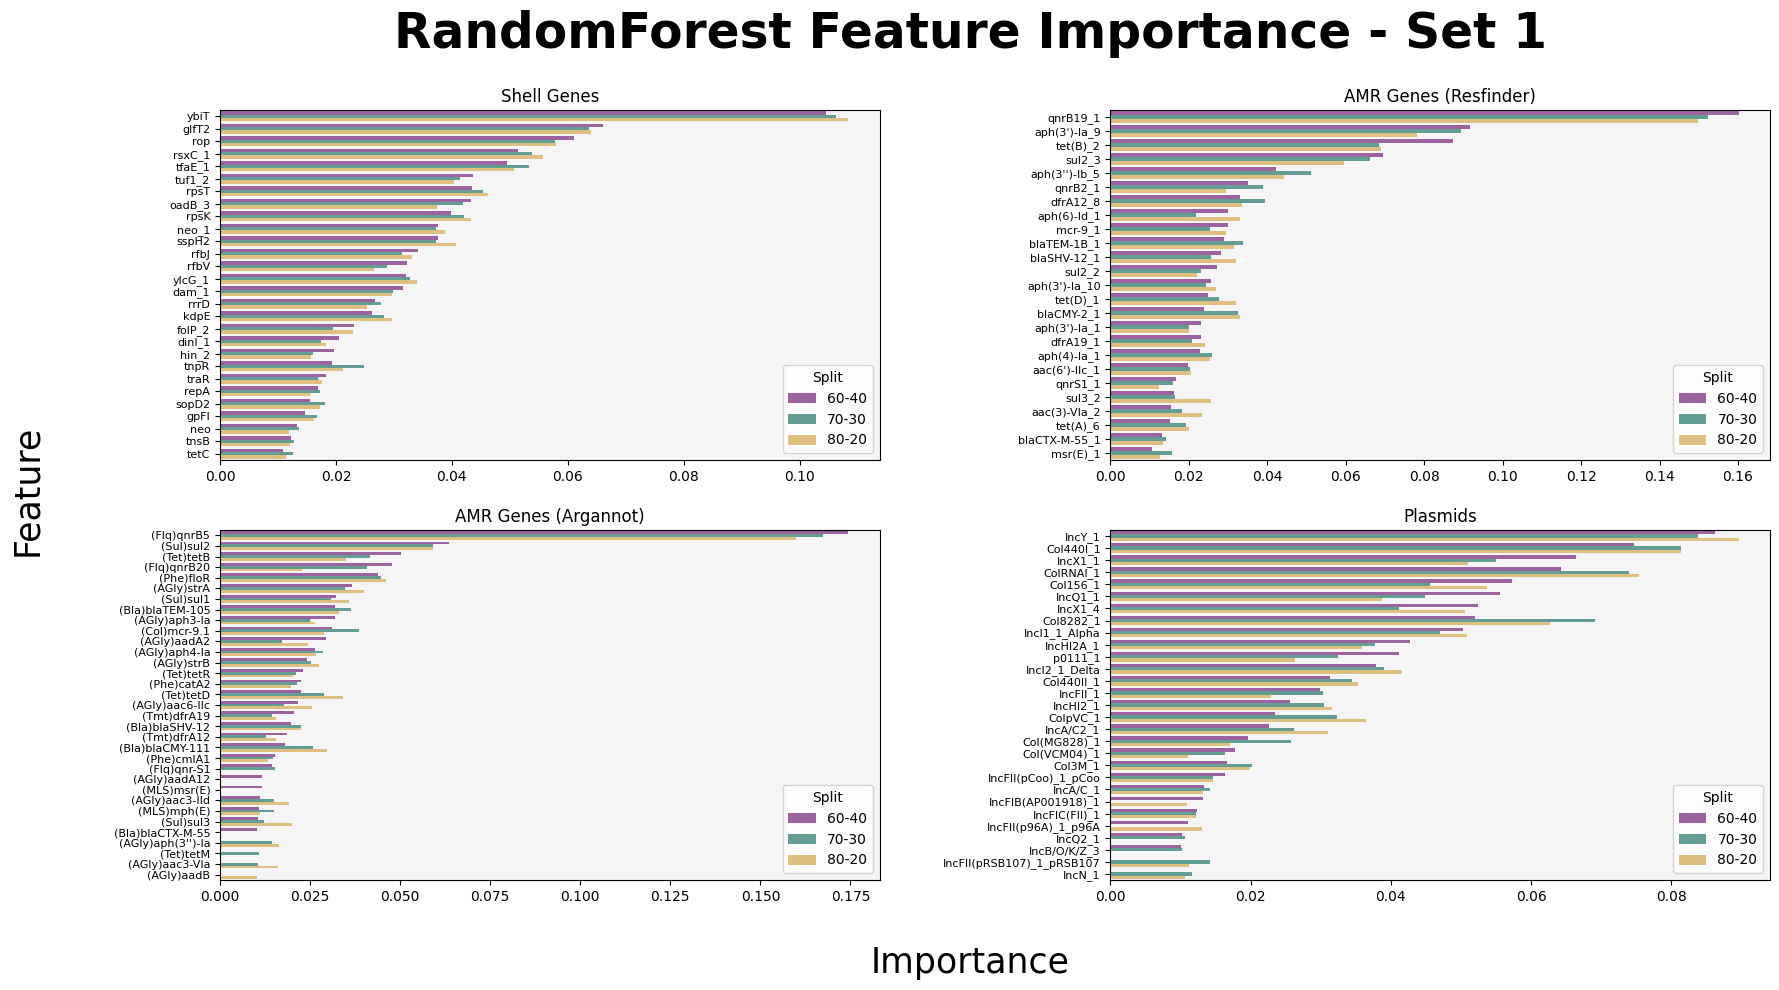

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
colors = ['#a559aa', '#59a89c', '#f0c571']
plt.subplots_adjust(wspace = 0.35)  # , hspace = 0.3

# Shell Genes
sg_plot = sns.barplot(sg_rf, x = 'Importance', y = 'Feature', hue = 'Split', 
                       palette = colors, ax = axs[0, 0])


sg_plot.set_title('Shell Genes')
sg_plot.set(xlabel = None, ylabel = None)
sg_plot.set_facecolor('whitesmoke')
# sg_plot.get_xaxis().set_visible(False)

sg_lab = sg_plot.get_yticklabels()
sg_plot.set_yticklabels(sg_lab , fontsize = 8)

# Resfinder
res_plot = sns.barplot(res_rf, x = 'Importance', y = 'Feature', hue = 'Split', 
                       palette = colors, ax = axs[0, 1])

res_plot.set_title('AMR Genes (ResFinder)')
res_plot.set(xlabel = None, ylabel = None)
res_plot.set_facecolor('whitesmoke')
# res_plot.get_xaxis().set_visible(False)

res_lab = res_plot.get_yticklabels()
res_plot.set_yticklabels(res_lab , fontsize = 8)

# Argannot
arg_plot = sns.barplot(arg_rf, x = 'Importance', y = 'Feature', hue = 'Split', 
                       palette = colors, ax = axs[1, 0])

arg_plot.set_title('AMR Genes (ARG-ANNOT)')
arg_plot.set(xlabel = None, ylabel = None)
arg_plot.set_facecolor('whitesmoke')

arg_lab = arg_plot.get_yticklabels()
arg_plot.set_yticklabels(arg_lab , fontsize = 8)

# Plasmids
pls_plot = sns.barplot(pls_rf, x = 'Importance', y = 'Feature', hue = 'Split', 
                       palette = colors, ax = axs[1, 1])

pls_plot.set_title('Plasmids')
pls_plot.set(xlabel = None, ylabel = None)
pls_plot.set_facecolor('whitesmoke')

pls_lab = pls_plot.get_yticklabels()
pls_plot.set_yticklabels(pls_lab , fontsize = 8)

plt.suptitle('RandomForest Feature Importance - Set 1', fontsize = '35', fontweight = 'bold')
fig.supxlabel('Importance', fontsize = '25')
fig.supylabel('Feature', fontsize = '25')
                 
plt.show()

### Clustermap

c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Clustermap Set 1')

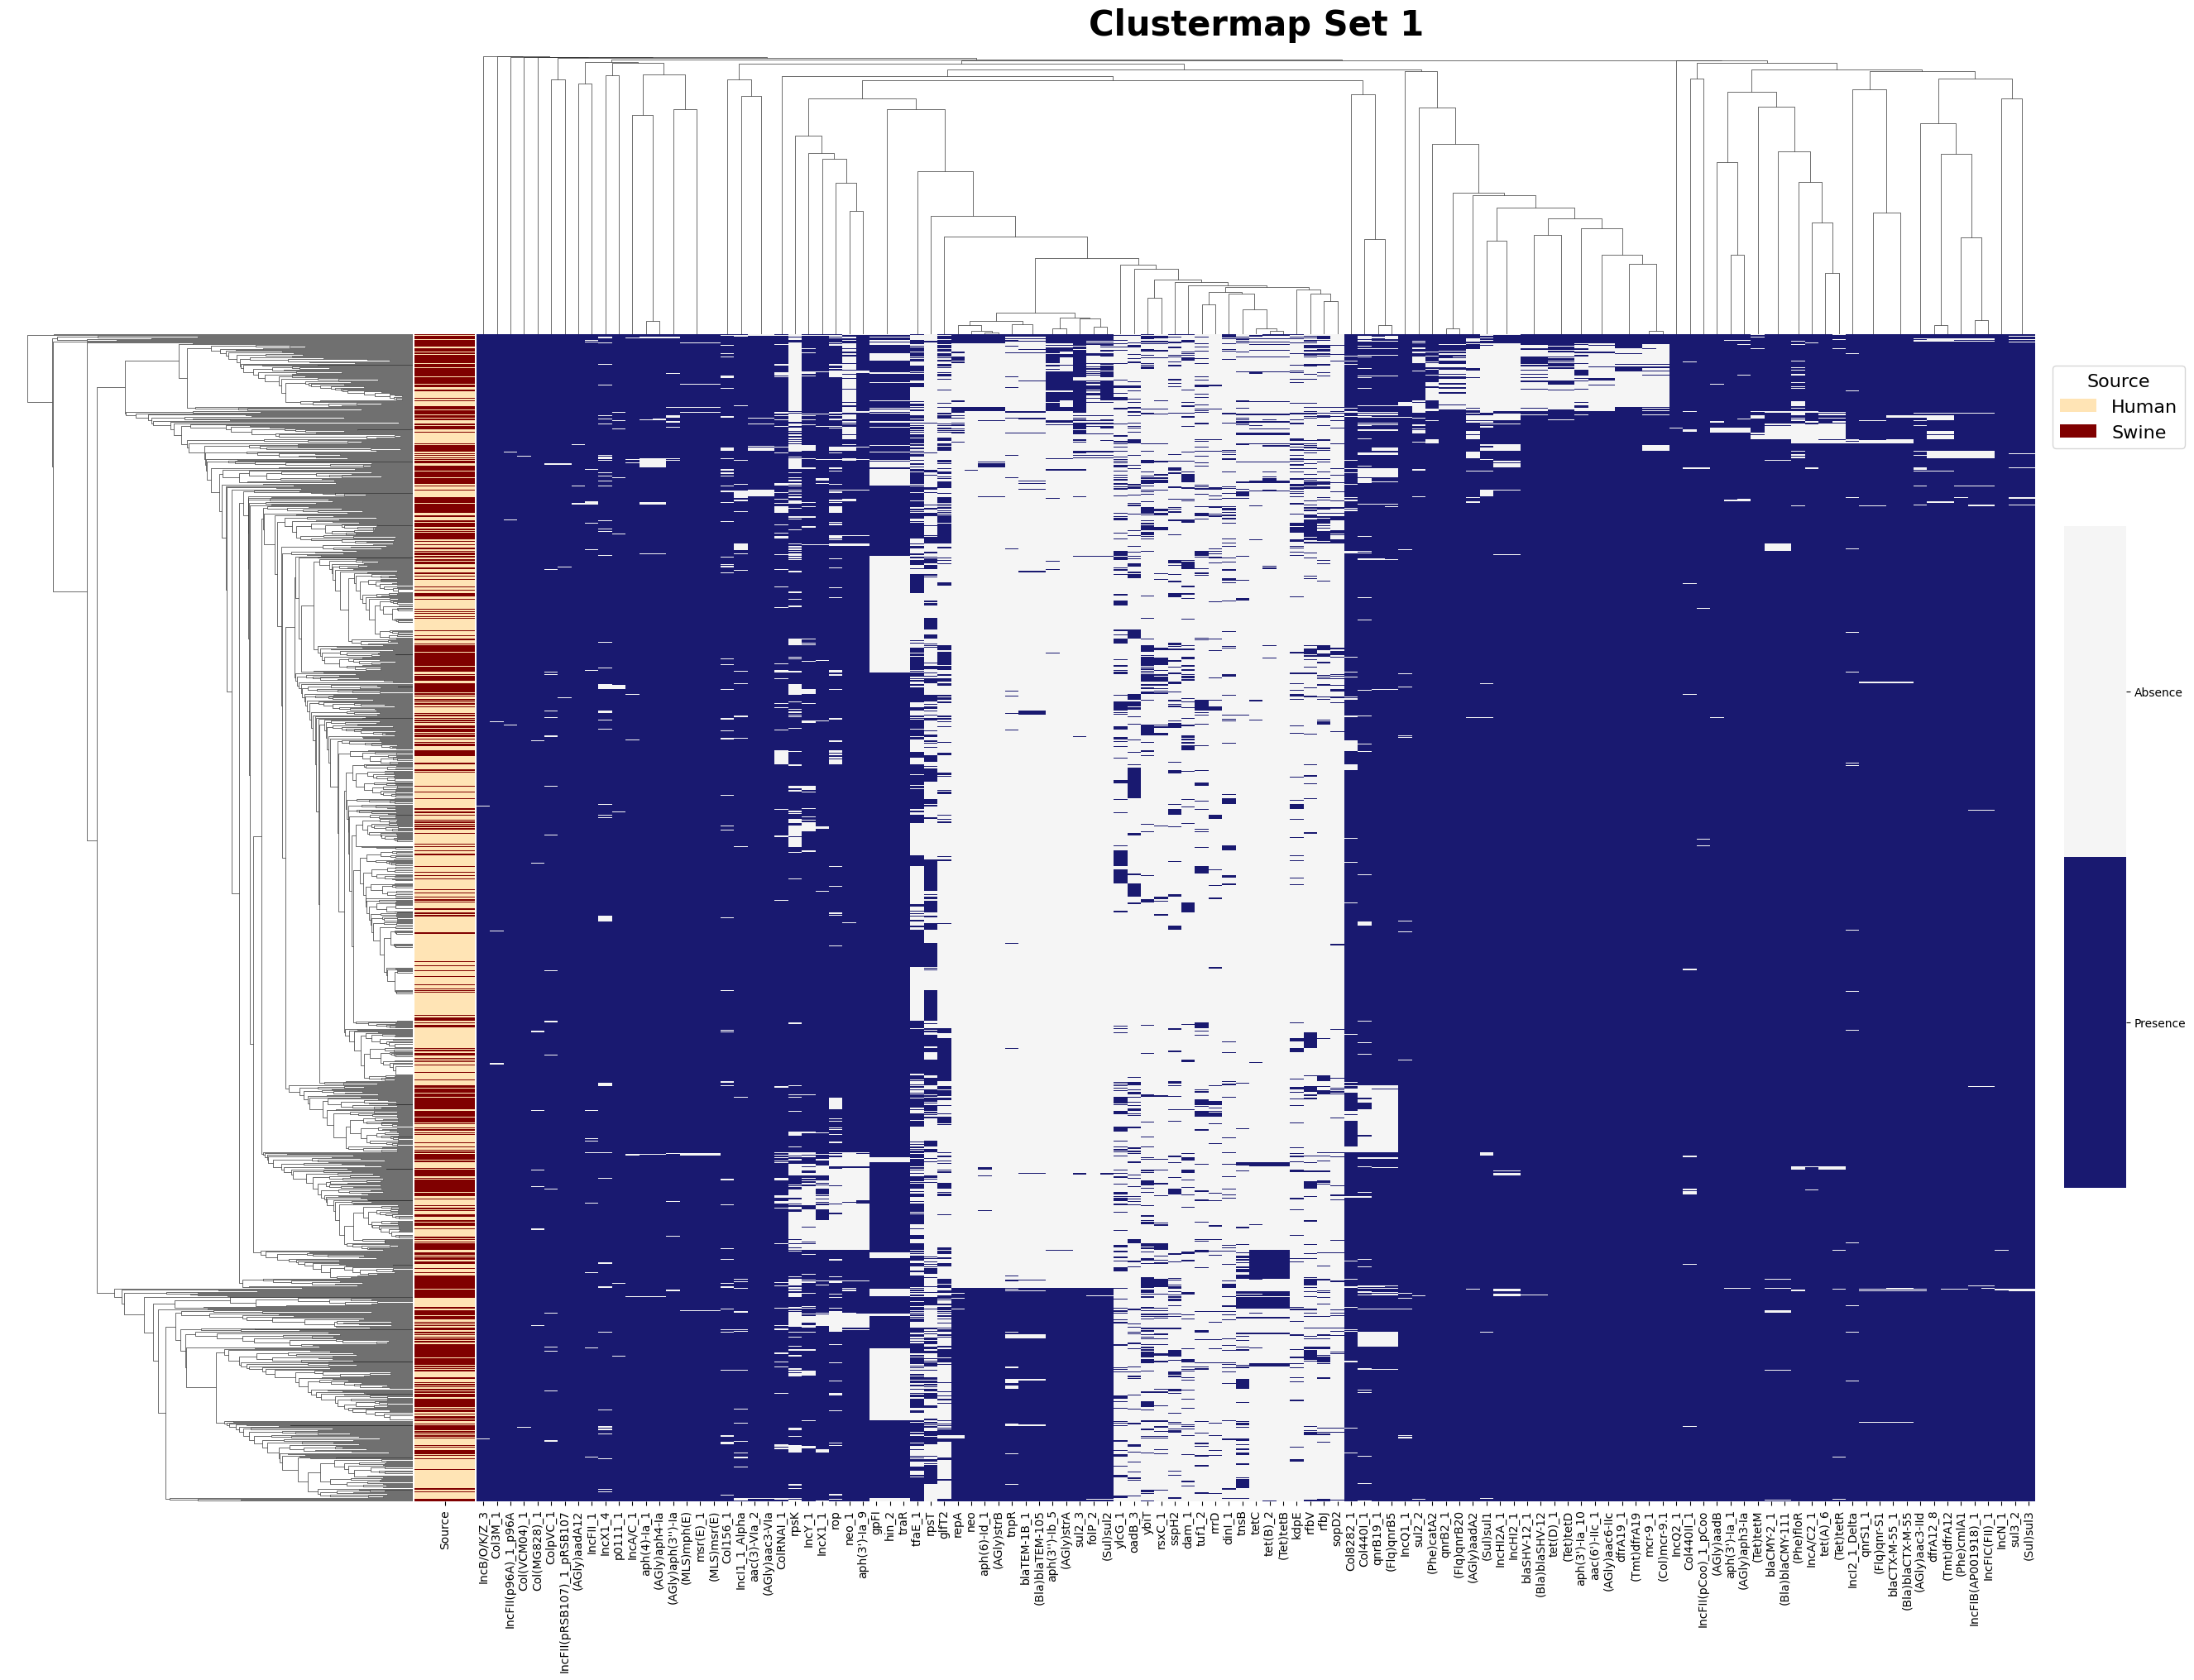

In [40]:
used_source = ['Human', 'Swine']
source_pal = sns.color_palette(['moccasin', 'maroon'])
source_lut = dict(zip(map(str, used_source), source_pal))

sources = top_features_merged.index.get_level_values('Source')
source_colors = pd.Series(sources, index = top_features_merged.index).map(source_lut)

cmap = sns.color_palette(['midnightblue', 'whitesmoke'])

set1 = sns.clustermap(top_features_merged, metric = 'jaccard', 
                      xticklabels = True, yticklabels = False,
                      cmap = cmap, cbar_pos = (1, .3, .03, .4),
                      row_colors = source_colors,
                      figsize=(25, 20))

category_order = ['Presence', 'Absence']    

#modify colorbar:
colorbar = set1.ax_heatmap.collections[0].colorbar.ax
colorbar.set_yticks([0.25, 0.75])
colorbar.set_yticklabels(category_order) 


for label in sources.unique().sort_values():
    set1.ax_col_dendrogram.bar(0, 0, color = source_lut[label],
                            label = label, linewidth = 0)
    
source_leg = set1.ax_col_dendrogram.legend(title = 'Source', title_fontsize = 16,
                                           bbox_to_anchor = (1.005, -0.25), 
                                           loc = 'center left',
                                           prop = {'size': 16})

ax = set1.ax_heatmap
ax.set_ylabel('')

set1.ax_col_dendrogram.set_title('Clustermap Set 1', fontsize = 30, fontweight = 'bold') 

### Heavy Metal Genes

c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Clustermap Set 1 - Heavy Metal Resistance Genes')

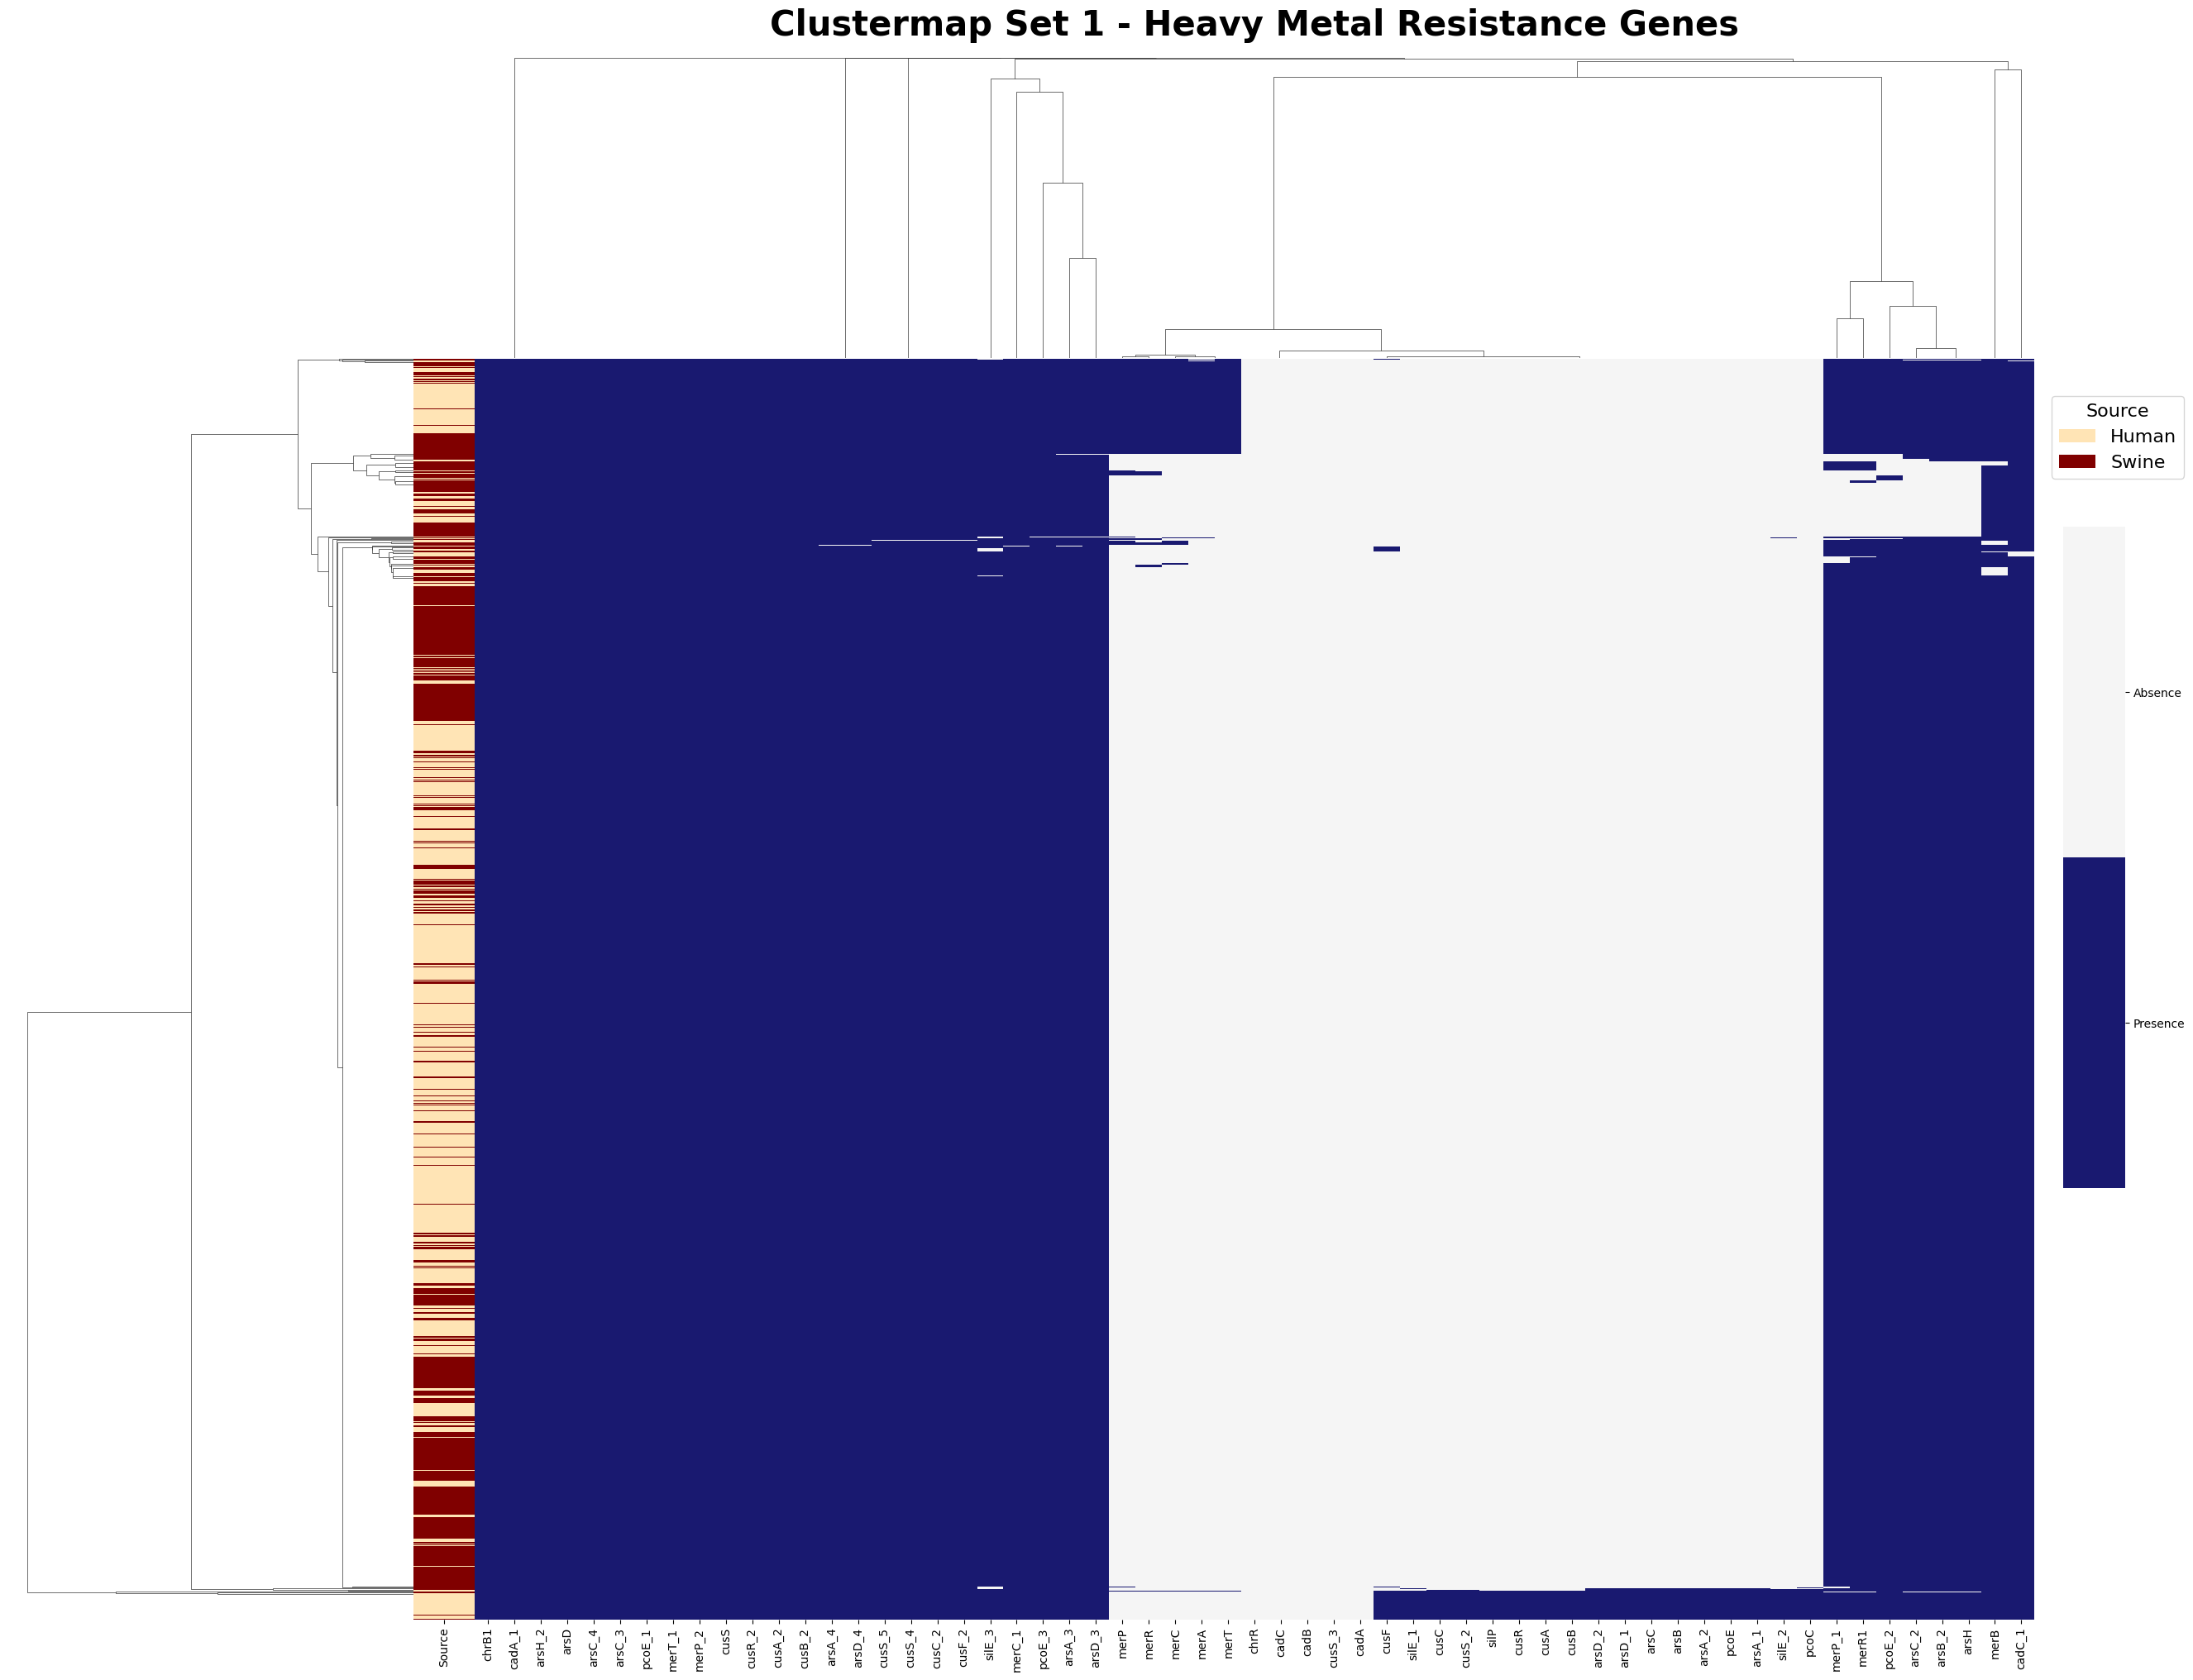

In [41]:
used_source_hm = ['Human', 'Swine']
source_pal_hm = sns.color_palette(['moccasin', 'maroon'])
source_lut_hm = dict(zip(map(str, used_source_hm), source_pal_hm))

sources_hm = heavy_metal_genes.index.get_level_values('Source')
source_colors_hm = pd.Series(sources_hm, index = heavy_metal_genes.index).map(source_lut_hm)

cmap = sns.color_palette(['midnightblue', 'whitesmoke'])

set1_hm = sns.clustermap(heavy_metal_genes, metric = 'jaccard', 
                      xticklabels = True, yticklabels = False,
                      cmap = cmap, cbar_pos = (1, .3, .03, .4),
                      row_colors = source_colors_hm,
                      figsize=(25, 20))

category_order = ['Presence', 'Absence']    

#modify colorbar:
colorbar_hm = set1_hm.ax_heatmap.collections[0].colorbar.ax
colorbar_hm.set_yticks([0.25, 0.75])
colorbar_hm.set_yticklabels(category_order) 


for label in sources_hm.unique().sort_values():
    set1_hm.ax_col_dendrogram.bar(0, 0, color = source_lut_hm[label],
                            label = label, linewidth = 0)
    
source_leg_hm = set1_hm.ax_col_dendrogram.legend(title = 'Source', title_fontsize = 16,
                                           bbox_to_anchor = (1.005, -0.25), 
                                           loc = 'center left',
                                           prop = {'size': 16})

ax_hm = set1_hm.ax_heatmap
ax_hm.set_ylabel('')

set1_hm.ax_col_dendrogram.set_title('Clustermap Set 1 - Heavy Metal Resistance Genes', fontsize = 30, fontweight = 'bold')

### Jaccard Analysis

#### Human

##### Elbow Plot

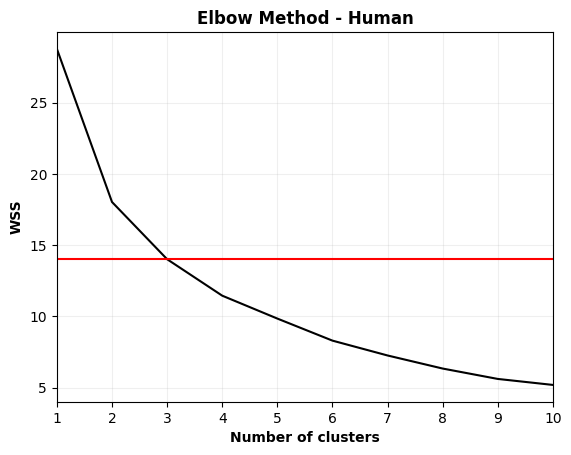

In [42]:
plt.plot(wss2_h['Clusters'], wss2_h['WSS'], color = 'k')
plt.title('Elbow Method - Human', fontweight = 'bold')
plt.xlabel('Number of clusters', fontweight = 'bold')
plt.ylabel('WSS', fontweight = 'bold')

plt.xticks(wss2_h['Clusters'])
plt.xlim(1, 10)

plt.axhline(y = wss2_h.loc[elbow_h, 'WSS'], color = 'r', linestyle = '-')

plt.grid(alpha = 0.2)

##### Kmeans Jaccard Clusters

In [43]:
jac_dist_h = px.scatter_3d(jac_dist_h, x = 'PC1', y = 'PC2', z = 'PC3', color = 'Jaccard',
                             category_orders = {'Jaccard': [1, 2, 3, 4]})
jac_dist_h.show()

#### Swine

##### Elbow Plot

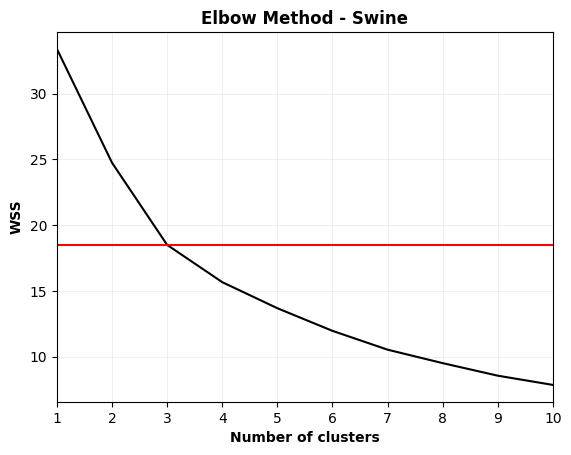

In [44]:
plt.plot(wss2_s['Clusters'], wss2_s['WSS'], color = 'k')
plt.title('Elbow Method - Swine', fontweight = 'bold')
plt.xlabel('Number of clusters', fontweight = 'bold')
plt.ylabel('WSS', fontweight = 'bold')

plt.xticks(wss2_s['Clusters'])
plt.xlim(1, 10)

plt.axhline(y = wss2_s.loc[elbow_s, 'WSS'], color = 'r', linestyle = '-')

plt.grid(alpha = 0.2)

##### Kmeans Jaccard Clusters

In [45]:
jac_dist_s = px.scatter_3d(jac_dist_s, x = 'PC1', y = 'PC2', z = 'PC3', color = 'Jaccard',
                             category_orders = {'Jaccard': [1, 2, 3, 4]})
jac_dist_s.show()

### Confusion Matrix Gene Proportion

C:\Users\steph\AppData\Local\Temp\ipykernel_11964\56384940.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\steph\AppData\Local\Temp\ipykernel_11964\56384940.py:28: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



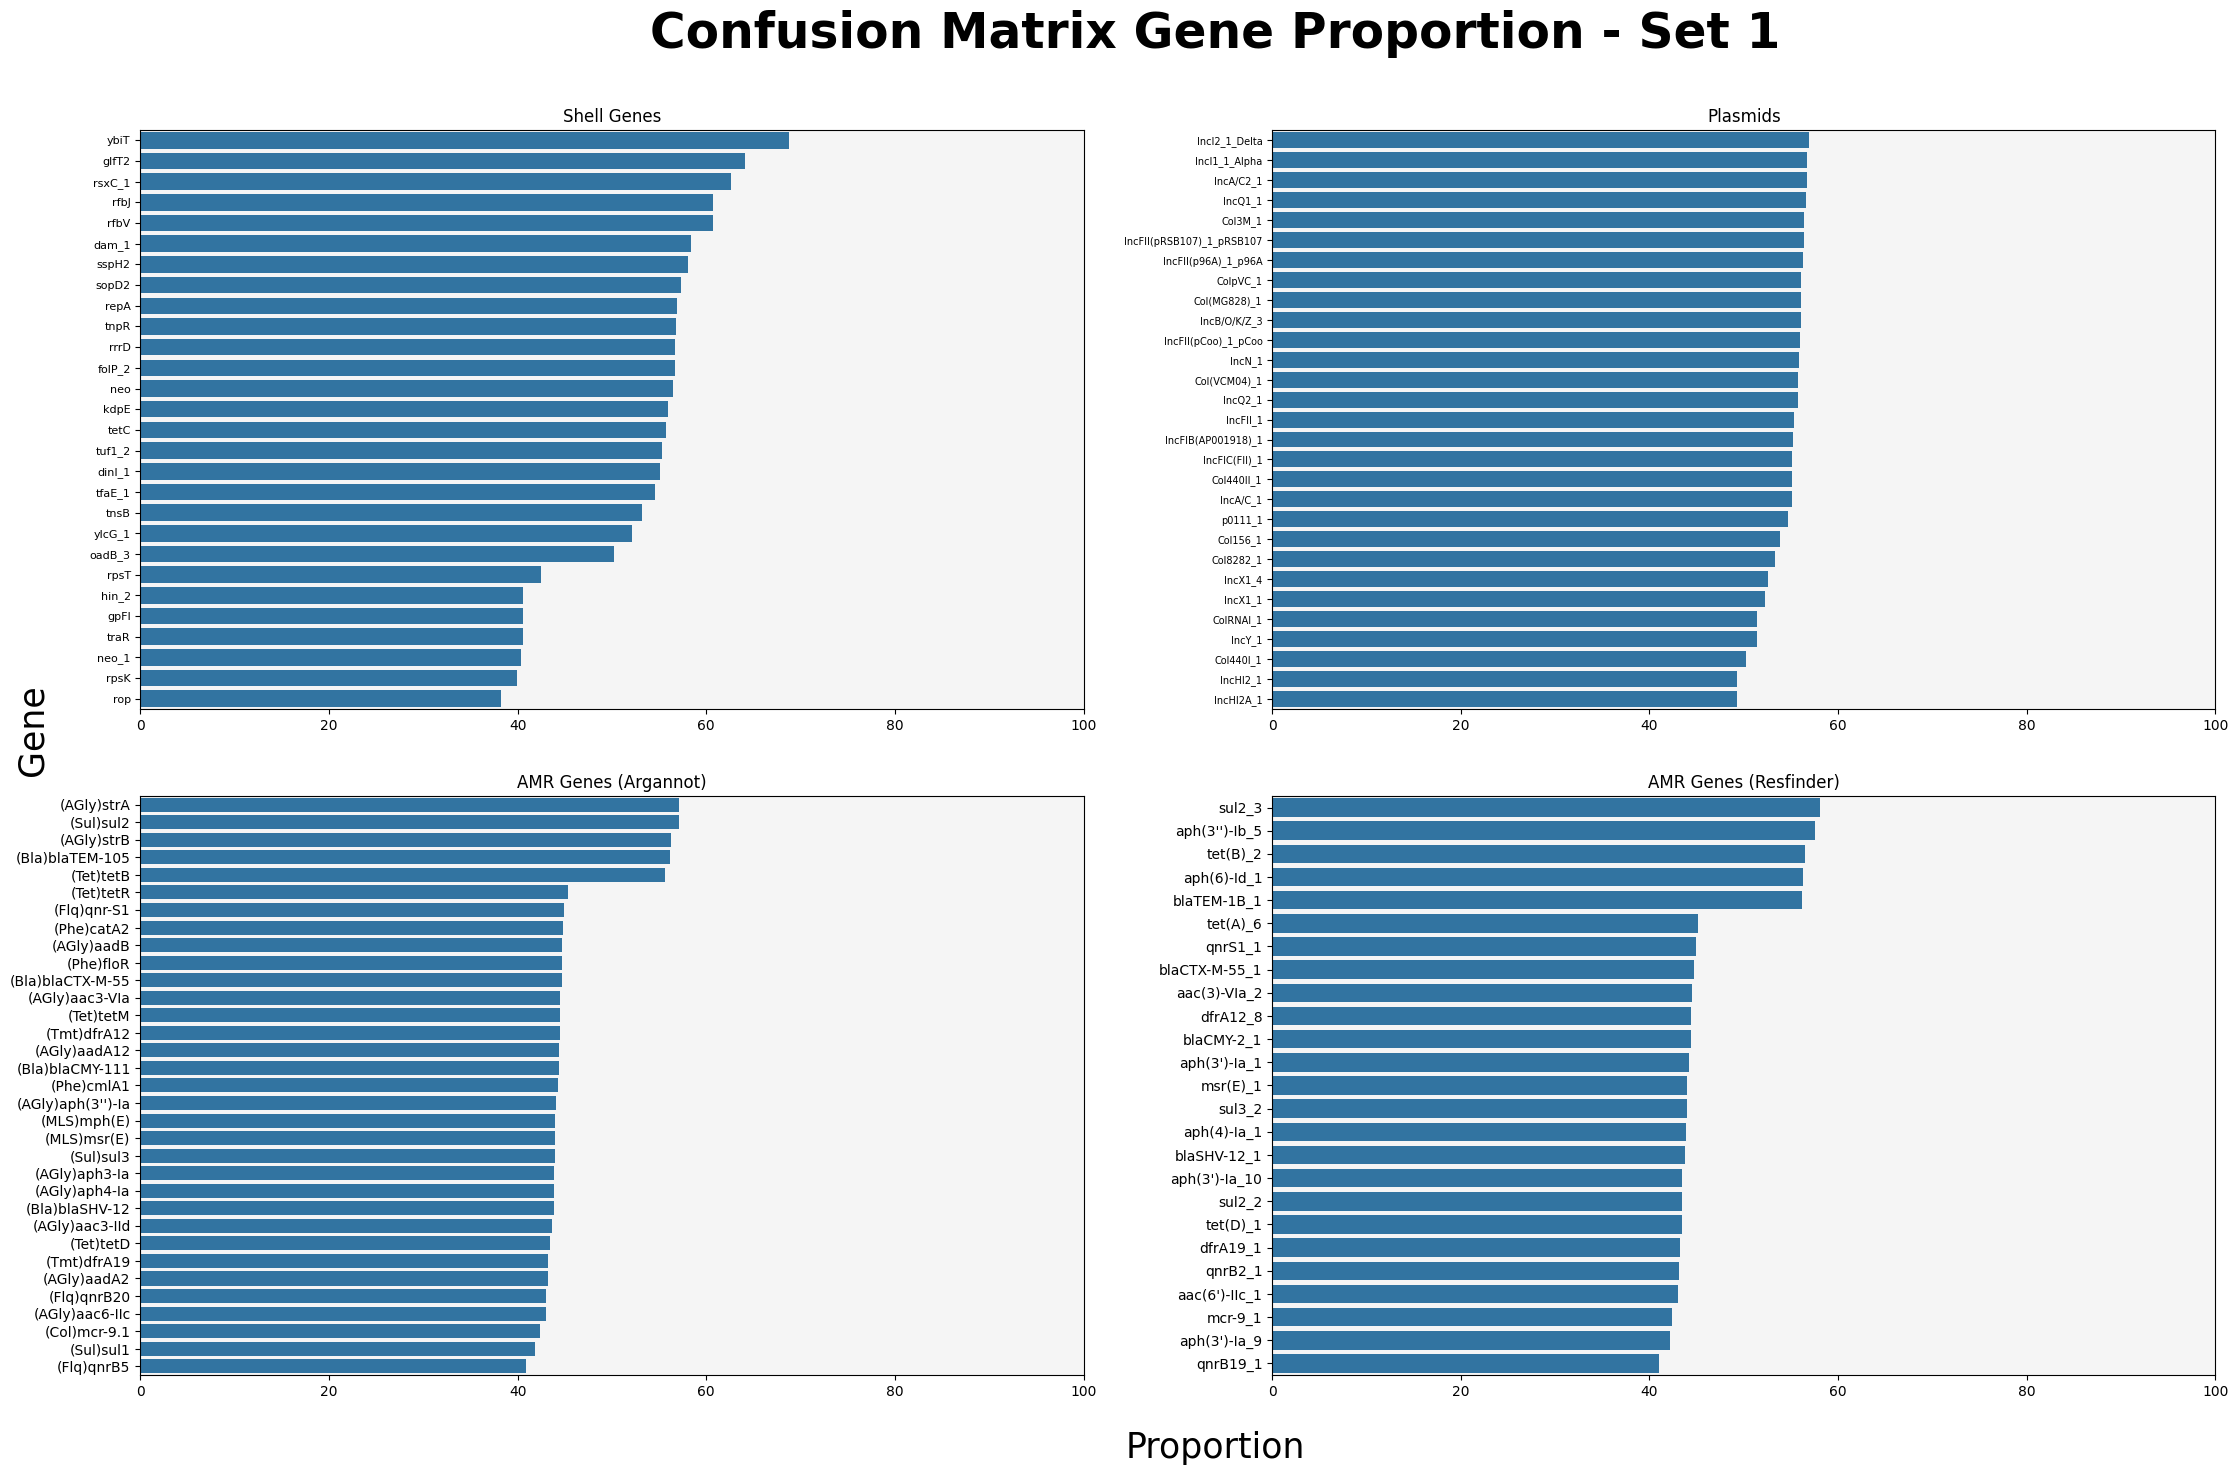

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (25, 15))

# Adjust spacing between subplots
plt.subplots_adjust(left = 0.07, right = 0.9, 
                    bottom =0.07, top = 0.9, 
                    wspace = 0.2, hspace = 0.15)

# Shell Genes
sg_plot = sns.barplot(cm_sg, x = 'Prop', y = 'Gene',
                      ax = axs[0, 0])

sg_plot.set_title('Shell Genes')
sg_plot.set(xlabel = None, ylabel = None)
sg_plot.set_facecolor('whitesmoke')

sg_lab = sg_plot.get_yticklabels()
sg_plot.set_yticklabels(sg_lab , fontsize = 8)

# Plasmids
pls_plot = sns.barplot(cm_pls, x = 'Prop', y = 'Gene',
                       ax = axs[0, 1])

pls_plot.set_title('Plasmids')
pls_plot.set(xlabel = None, ylabel = None)
pls_plot.set_facecolor('whitesmoke')

pls_lab = pls_plot.get_yticklabels()
pls_plot.set_yticklabels(pls_lab , fontsize = 7)

# Argannot
arg_plot = sns.barplot(cm_arg, x = 'Prop', y = 'Gene',
                       ax = axs[1, 0])

arg_plot.set_title('AMR Genes (ARG-ANNOT)')
arg_plot.set(xlabel = None, ylabel = None)
arg_plot.set_facecolor('whitesmoke')

arg_lab = arg_plot.get_yticklabels()
# arg_plot.set_yticklabels(arg_lab , fontsize = 8)

# Resfinder
res_plot = sns.barplot(cm_res, x = 'Prop', y = 'Gene',
                       ax = axs[1, 1])

res_plot.set_title('AMR Genes (ResFinder)')
res_plot.set(xlabel = None, ylabel = None)
res_plot.set_facecolor('whitesmoke')

res_lab = res_plot.get_yticklabels()
# res_plot.set_yticklabels(res_lab , fontsize = 8)

plt.suptitle('Confusion Matrix Gene Proportion - Set 1', fontsize = '35', fontweight = 'bold')
fig.supxlabel('Proportion', fontsize = '25')
fig.supylabel('Gene', fontsize = '25')
plt.setp(axs, xlim = (0, 100))

plt.show()

### Random Forest Combined Feature Importance

C:\Users\steph\AppData\Local\Temp\ipykernel_11964\2540288146.py:4: UserWarning:

The palette list has more values (3) than needed (2), which may not be intended.



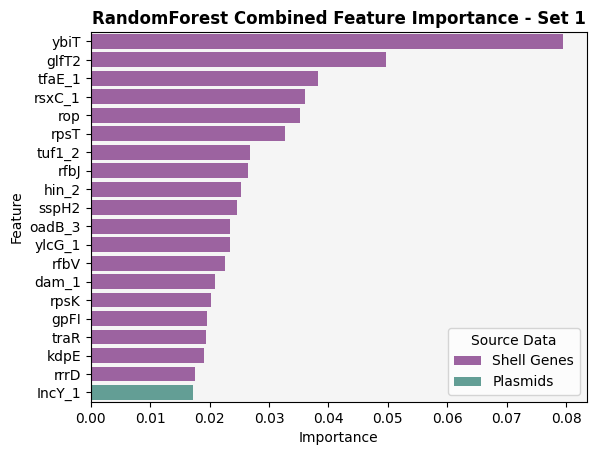

In [47]:
colors = ['#a559aa', '#59a89c', '#f0c571']

# Shell Genes
rf_plot = sns.barplot(total_rf, x = 'Importance', y = 'Feature', hue = 'Source Data', 
                       palette = colors)


# sg_plot.set_title('idk yet')
rf_plot.set(xlabel = None, ylabel = None)
rf_plot.set_facecolor('whitesmoke')


rf_plot.set_title('RandomForest Combined Feature Importance - Set 1', fontweight = 'bold')
rf_plot.set(xlabel = 'Importance', ylabel = 'Feature')
rf_plot.set_facecolor('whitesmoke')
        
plt.show()